In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Car Mileage Prediction

## Problem Statement
The goal of this project is to build a regression model to predict car fuel efficiency
using vehicle specifications, engine characteristics, and design-related features.

## Why this matters
Fuel efficiency prediction helps manufacturers and buyers make informed decisions
about cost, performance, and environmental impact.


In [2]:
# ===============================
# COMPLETE IMPORTS: EDA → REGRESSION
# ===============================

# Core
import numpy as np
import pandas as pd

# Utilities
import os
import sys
import warnings
warnings.filterwarnings("ignore")

# Visualization (EDA)
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics
from scipy import stats
from scipy.stats import skew, kurtosis

# Preprocessing & Feature Engineering
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    OneHotEncoder,
    LabelEncoder,
    PolynomialFeatures
)
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Regression Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Advanced Regressors (optional)
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
# from catboost import CatBoostRegressor

# Feature Selection
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

# Evaluation Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Model Persistence
import joblib
import pickle

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [3]:
data_path = '/content/drive/MyDrive/Gen AI GL/Regression Project/Car_Meilage_Prediction/data/'

data_num = pd.read_csv(data_path + 'cleaned_num_data_cars.csv')
data_cat = pd.read_csv(data_path + 'cleaned_cat_endoded_data_cars.csv')

df_num = data_num.copy()
df_cat = data_cat.copy()

In [4]:
# Concatenate numeric & categoric columns
df = pd.concat([df_num, df_cat], axis=1)

# Check result
print(df.shape)
df.head()

(5058, 24)


,no_of_gears,city_mpg,highway_mpg,car_volume,Power_Index,Car_Age,Avg_MPG,displacement,cylinders,hp,torque,car_body_type_Others,car_body_type_Pickup Truck,car_body_type_SUV / Crossover,car_body_type_Sedan,driveline_style_Four-wheel drive,driveline_style_Front-wheel drive,driveline_style_Rear-wheel drive,transmission_type_Automatic Select Shift,transmission_type_Manual,fuel_type_Diesel fuel,fuel_type_E85,fuel_type_Gasoline,market_segment_Luxury
0,6.0,18,25,4044040,16.433578,16,21.5,3.2,6.0,250.0,236.0,True,False,False,False,False,False,False,True,False,False,False,True,True
1,6.0,22,28,4044040,13.146863,16,25.0,2.0,4.0,200.0,207.0,True,False,False,False,False,True,False,True,False,False,False,True,True
2,6.0,21,30,4044040,13.146863,16,25.5,2.0,4.0,200.0,207.0,True,False,False,False,False,True,False,False,True,False,False,True,True
3,6.0,21,28,4044040,13.146863,16,24.5,2.0,4.0,200.0,207.0,True,False,False,False,False,False,False,True,False,False,False,True,True
4,6.0,16,27,95914,23.101296,16,21.5,3.2,6.0,265.0,243.0,True,False,False,False,False,False,False,False,True,False,False,True,True


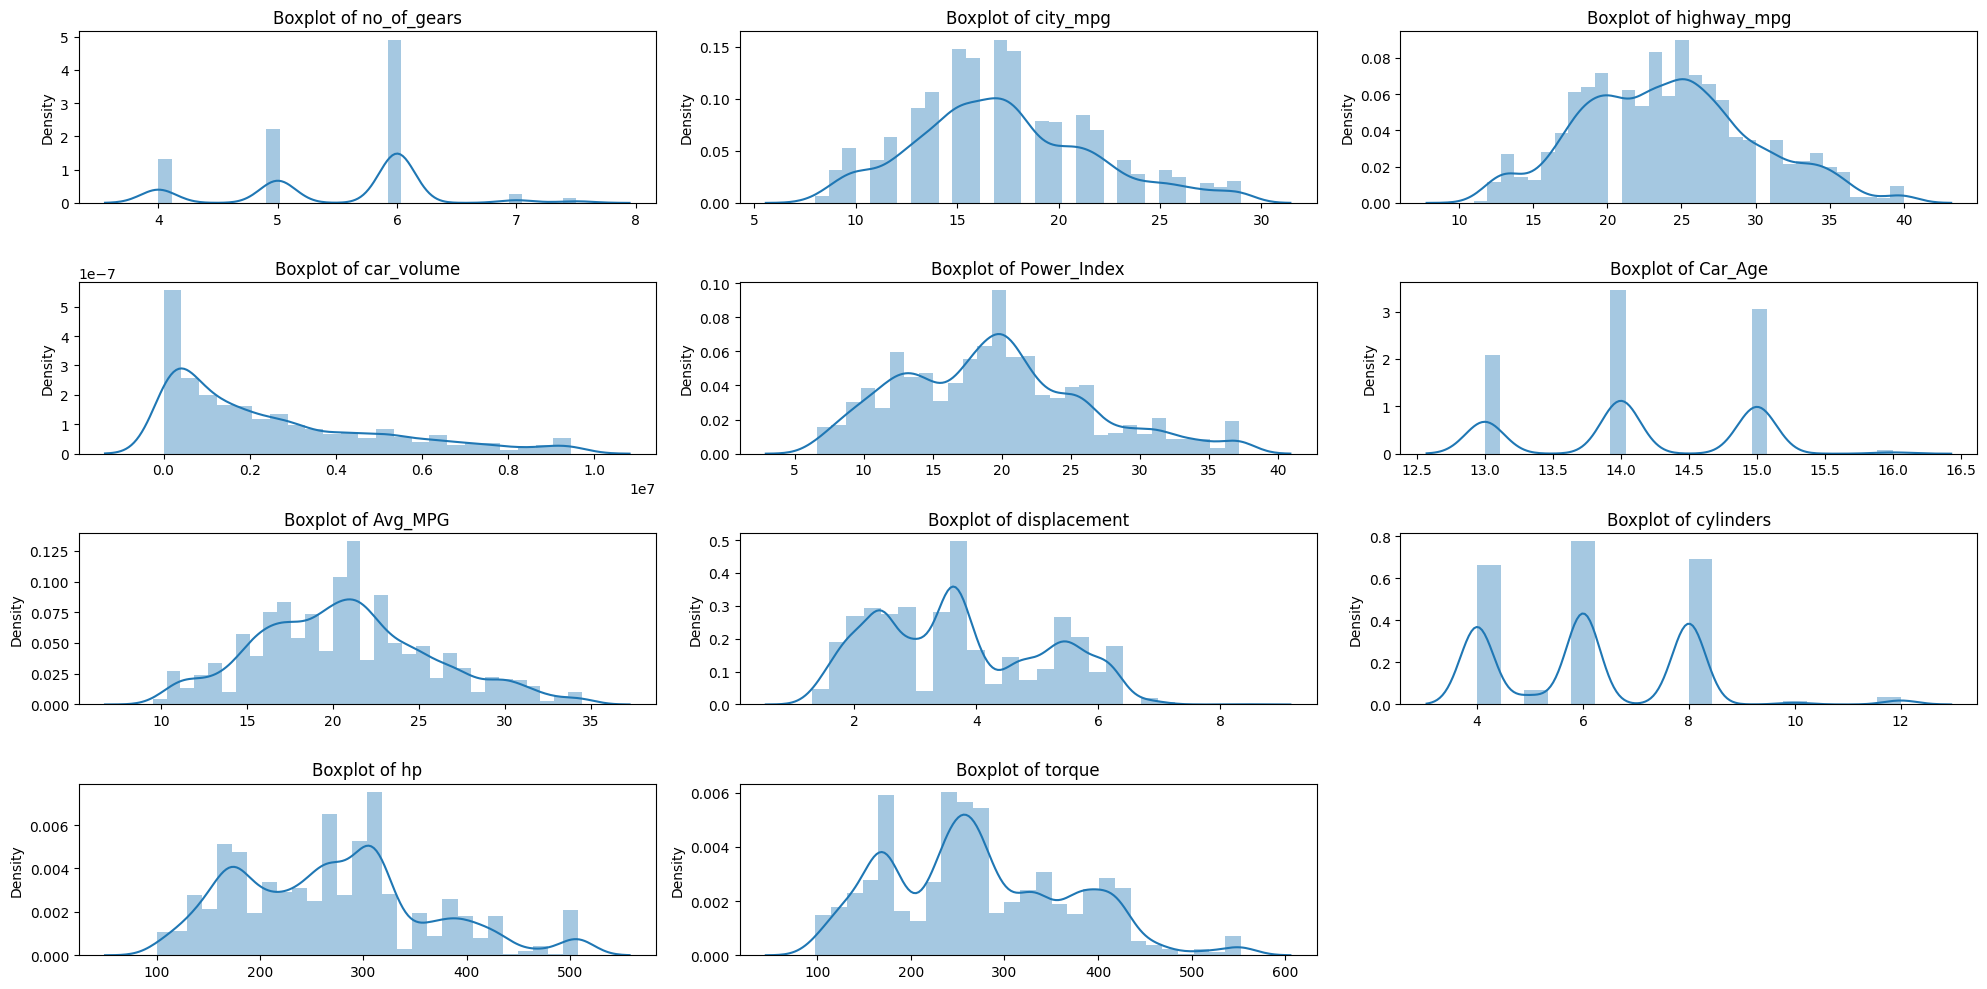

In [5]:
plt.figure(figsize=(20,10))

t=1
for i in df_num.columns:
  plt.subplot(4,3,t)
  sns.distplot(x=df_num[i])
  plt.title(f'Boxplot of {i}')
  t+=1
plt.tight_layout()
plt.show()

In [6]:
targets = ['city_mpg','highway_mpg','Avg_MPG']

X = df.drop(columns=['city_mpg','highway_mpg','Avg_MPG'])
y = df['Avg_MPG']

In [7]:
# Step 1: split off test set (10%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, shuffle=True
)

# Step 2: split remaining 90% into train (80%) and validation (10%)
# Note: validation_size = 0.1 / 0.9 ≈ 0.1111 of X_temp
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1111, random_state=42, shuffle=True
)

# Check sizes
print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")
print(f"Train: {y_train.shape}, Validation: {y_val.shape}, Test: {y_test.shape}")

Train: (4046, 21), Validation: (506, 21), Test: (506, 21)
Train: (4046,), Validation: (506,), Test: (506,)


In [8]:
# ---------------- Log-transform skewed features ----------------
log_cols = ['car_volume', 'hp', 'torque']

# Fit only on train, apply transform to val and test
X_train[log_cols] = np.log1p(X_train[log_cols])
X_val[log_cols]   = np.log1p(X_val[log_cols])
X_test[log_cols]  = np.log1p(X_test[log_cols])

# ---------------- Standard scaling of selected columns ----------------
scale_cols = ['Power_Index', 'displacement']

scaler = StandardScaler()
X_train[scale_cols] = scaler.fit_transform(X_train[scale_cols])
X_val[scale_cols]   = scaler.transform(X_val[scale_cols])
X_test[scale_cols]  = scaler.transform(X_test[scale_cols])

In [9]:
X_train.head()

,no_of_gears,car_volume,Power_Index,Car_Age,displacement,cylinders,hp,torque,car_body_type_Others,car_body_type_Pickup Truck,car_body_type_SUV / Crossover,car_body_type_Sedan,driveline_style_Four-wheel drive,driveline_style_Front-wheel drive,driveline_style_Rear-wheel drive,transmission_type_Automatic Select Shift,transmission_type_Manual,fuel_type_Diesel fuel,fuel_type_E85,fuel_type_Gasoline,market_segment_Luxury
1121,6.0,12.087295,-0.415917,14,-1.247373,4.0,5.303305,5.337538,False,False,True,False,False,True,False,False,False,False,False,True,False
4777,6.0,14.172122,2.446643,13,0.939658,8.0,6.231465,6.220590,True,False,False,False,False,False,True,True,False,False,False,True,True
2286,6.0,14.542093,0.344169,14,-0.518363,6.0,5.755742,5.802118,False,False,False,True,False,False,True,True,False,False,False,True,True
1222,4.0,15.258494,-0.683459,14,0.064846,6.0,5.420535,5.545177,False,False,False,True,False,True,False,True,False,False,False,True,False
2420,5.0,13.619205,-0.681574,15,-0.955769,4.0,5.308268,5.141664,True,False,False,False,False,True,False,True,False,False,False,True,True


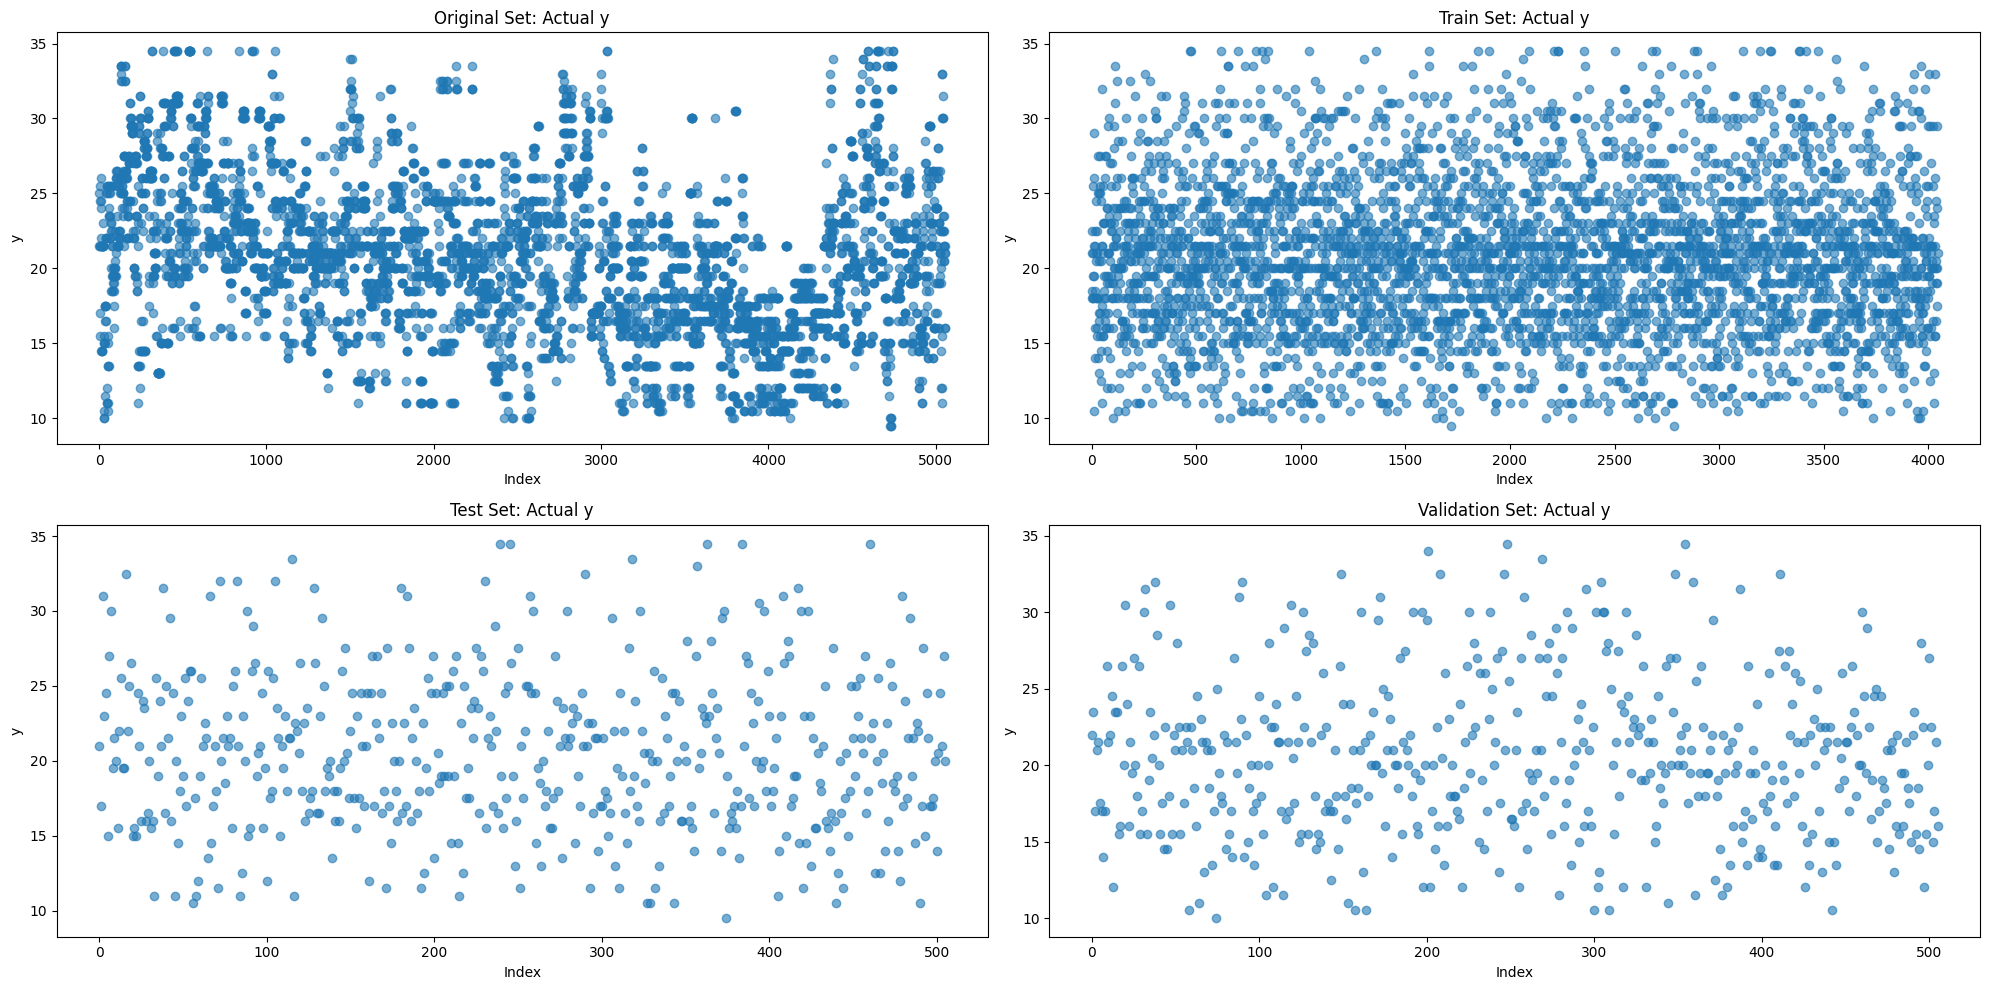

In [10]:
import matplotlib.pyplot as plt

# -------------------------
# Actual y values
# -------------------------
y_data = {
    'Original': y,        # full target before split
    'Train': y_train,
    'Test': y_test,
    'Validation': y_val
}

# -------------------------
# Plot actual y values
# -------------------------
plt.figure(figsize=(20,10))

for i, (dataset, y_actual) in enumerate(y_data.items(), 1):
    plt.subplot(2, 2, i)
    plt.scatter(range(len(y_actual)), y_actual, alpha=0.6)
    plt.xlabel('Index')
    plt.ylabel('y')
    plt.title(f'{dataset} Set: Actual y')

plt.tight_layout()
plt.show()


In [11]:
def run_regression(model, X_train, X_test, y_train, y_test):
    """
    Fits a regression model and returns predictions and evaluation metrics.
    """

    # ------------------------------
    # Train model
    # ------------------------------
    model.fit(X_train, y_train)

    # ------------------------------
    # Predictions
    # ------------------------------
    ypred_train = model.predict(X_train)
    ypred_test = model.predict(X_test)

    return model, X_train, X_test, y_train, y_test, ypred_train, ypred_test

In [12]:
# ================================================================
# REGRESSION METRICS FUNCTION (Auto Train + Test)
# ================================================================

results_df = pd.DataFrame(columns=[
    'Model', 'Data', 'MAE', 'MSE', 'RMSE', 'R2', 'Adj_R2'
])

def evaluate_regression(model_name,
                        model,
                        X_train, X_test,
                        y_train, y_test):

    global results_df

    def compute_metrics(X, y_true, y_pred, label):
        mae  = mean_absolute_error(y_true, y_pred)
        mse  = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        r2   = r2_score(y_true, y_pred)

        n = X.shape[0]
        k = X.shape[1]
        adj_r2 = 1 - ((1 - r2) * (n - 1) / (n - k - 1))

        results_df.loc[len(results_df)] = [
            model_name, label, mae, mse, rmse, r2, adj_r2
        ]

        print(f"\n=== {model_name} | {label} ===")
        print(f"MAE      : {mae:.4f}")
        print(f"MSE      : {mse:.4f}")
        print(f"RMSE     : {rmse:.4f}")
        print(f"R²       : {r2:.4f}")
        print(f"Adj R²   : {adj_r2:.4f}")

    # AUTO predictions
    y_pred_train = model.predict(X_train)
    y_pred_test  = model.predict(X_test)

    compute_metrics(X_train, y_train, y_pred_train, "Train")
    compute_metrics(X_test,  y_test,  y_pred_test,  "Test")

    return results_df

Linear Regression

In [13]:
# Baseline
lr, X_train, X_test, y_train, y_test, ypred_train, ypred_test = run_regression(
    LinearRegression(),
    X_train, X_test, y_train, y_test
)

evaluate_regression('Linear',lr, X_train, X_test, y_train, y_test)


=== Linear | Train ===
MAE      : 1.4057
MSE      : 3.4262
RMSE     : 1.8510
R²       : 0.8662
Adj R²   : 0.8655

=== Linear | Test ===
MAE      : 1.3969
MSE      : 3.4532
RMSE     : 1.8583
R²       : 0.8747
Adj R²   : 0.8693


,Model,Data,MAE,MSE,RMSE,R2,Adj_R2
0,Linear,Train,1.405715,3.426199,1.85100,0.866246,0.865548
1,Linear,Test,1.396932,3.453242,1.85829,0.874743,0.869308


In [14]:
# Ridge
ridge_reg, X_train, X_test, y_train, y_test, ypred_train, ypred_test = run_regression(
    Ridge(alpha=1.0),
    X_train, X_test, y_train, y_test
)

evaluate_regression('Ridge',ridge_reg, X_train, X_test, y_train, y_test)

# Lasso
lasso_reg, X_train, X_test, y_train, y_test, ypred_train, ypred_test = run_regression(
    Lasso(alpha=0.01),
    X_train, X_test, y_train, y_test
)

evaluate_regression('Lasso',lasso_reg, X_train, X_test, y_train, y_test)


=== Ridge | Train ===
MAE      : 1.4063
MSE      : 3.4275
RMSE     : 1.8513
R²       : 0.8662
Adj R²   : 0.8655

=== Ridge | Test ===
MAE      : 1.3974
MSE      : 3.4583
RMSE     : 1.8597
R²       : 0.8746
Adj R²   : 0.8691

=== Lasso | Train ===
MAE      : 1.4252
MSE      : 3.4954
RMSE     : 1.8696
R²       : 0.8635
Adj R²   : 0.8628

=== Lasso | Test ===
MAE      : 1.4153
MSE      : 3.5527
RMSE     : 1.8849
R²       : 0.8711
Adj R²   : 0.8655


,Model,Data,MAE,MSE,RMSE,R2,Adj_R2
0,Linear,Train,1.405715,3.426199,1.851000,0.866246,0.865548
1,Linear,Test,1.396932,3.453242,1.858290,0.874743,0.869308
2,Ridge,Train,1.406322,3.427471,1.851343,0.866196,0.865498
3,Ridge,Test,1.397385,3.458343,1.859662,0.874558,0.869115
4,Lasso,Train,1.425221,3.495396,1.869598,0.863545,0.862832
5,Lasso,Test,1.415259,3.552675,1.884854,0.871136,0.865545


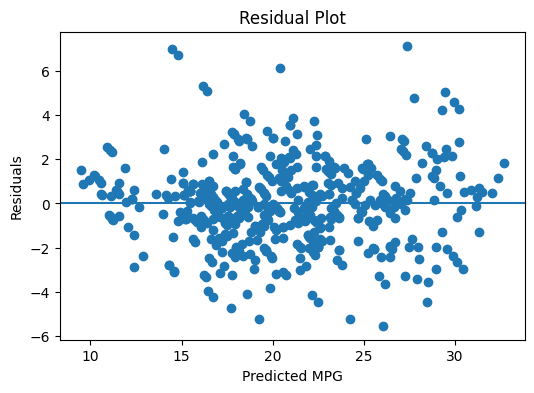

In [15]:
import matplotlib.pyplot as plt

residuals = y_test - lr.predict(X_test)

plt.figure(figsize=(6,4))
plt.scatter(lr.predict(X_test), residuals)
plt.axhline(0)
plt.xlabel("Predicted MPG")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

In [16]:
# Copy dataset to avoid overwriting
X_fe = X.copy()

# Identify skewed numerical features
skewness = X_fe.skew().sort_values(ascending=False)
skewness

,0
fuel_type_Diesel fuel,13.844035
fuel_type_E85,2.862875
driveline_style_Four-wheel drive,1.656687
car_body_type_SUV / Crossover,1.641193
car_body_type_Pickup Truck,1.641193
transmission_type_Manual,1.338079
market_segment_Luxury,1.256393
car_body_type_Sedan,1.221634
car_volume,1.068210
driveline_style_Front-wheel drive,0.821857


In [17]:
# Get skewed features with |skewness| > 0.75
skewed_features = skewness[skewness.abs() > 0.75].index

# Ensure they are in df_num.columns (numerical only)
skewed_num_cols = [col for col in df_num.columns if col in skewed_features]

print("Skewed numerical columns:", skewed_num_cols)

Skewed numerical columns: ['car_volume']


### Apply log transform (threshold = |skew| > 0.75)

In [18]:
X_fe[skewed_num_cols] = np.log1p(X_fe[skewed_num_cols])

X_fe['car_volume'].skew()

np.float64(-0.9244799053416869)

### Decision Tree

In [19]:

dt, X_train, X_test, y_train, y_test, ypred_train, ypred_test = run_regression(
    DecisionTreeRegressor(random_state=42),
    X_train, X_test, y_train, y_test
)

evaluate_regression('Decision Tree',dt, X_train, X_test, y_train, y_test)


=== Decision Tree | Train ===
MAE      : 0.0151
MSE      : 0.0186
RMSE     : 0.1363
R²       : 0.9993
Adj R²   : 0.9993

=== Decision Tree | Test ===
MAE      : 0.2325
MSE      : 0.4844
RMSE     : 0.6960
R²       : 0.9824
Adj R²   : 0.9817


,Model,Data,MAE,MSE,RMSE,R2,Adj_R2
0,Linear,Train,1.405715,3.426199,1.851000,0.866246,0.865548
1,Linear,Test,1.396932,3.453242,1.858290,0.874743,0.869308
2,Ridge,Train,1.406322,3.427471,1.851343,0.866196,0.865498
3,Ridge,Test,1.397385,3.458343,1.859662,0.874558,0.869115
4,Lasso,Train,1.425221,3.495396,1.869598,0.863545,0.862832
5,Lasso,Test,1.415259,3.552675,1.884854,0.871136,0.865545
6,Decision Tree,Train,0.015126,0.018584,0.136324,0.999274,0.999271
7,Decision Tree,Test,0.232543,0.484409,0.695995,0.982429,0.981667


Unregularized Decision Tree

Train RMSE: 0.13

Test RMSE: 0.69

Huge gap → ❌ Severe overfitting

Control Overfitting in Decision Tree (Tree Regularization)

Before moving to Random Forest, we must fix this tree.

We’ll do this by limiting:

Tree depth

Minimum samples per leaf

No GridSearch yet. Simple, controlled tuning.

In [20]:

dt_reg, X_train, X_test, y_train, y_test, ypred_train, ypred_test = run_regression(
    DecisionTreeRegressor(max_depth=6, min_samples_leaf=10, random_state=42),
    X_train, X_test, y_train, y_test
)

evaluate_regression('Decision Tree - Regularized',dt_reg, X_train, X_test, y_train, y_test)


=== Decision Tree - Regularized | Train ===
MAE      : 1.1232
MSE      : 2.3836
RMSE     : 1.5439
R²       : 0.9069
Adj R²   : 0.9065

=== Decision Tree - Regularized | Test ===
MAE      : 1.1476
MSE      : 2.4222
RMSE     : 1.5563
R²       : 0.9121
Adj R²   : 0.9083


,Model,Data,MAE,MSE,RMSE,R2,Adj_R2
0,Linear,Train,1.405715,3.426199,1.851000,0.866246,0.865548
1,Linear,Test,1.396932,3.453242,1.858290,0.874743,0.869308
2,Ridge,Train,1.406322,3.427471,1.851343,0.866196,0.865498
3,Ridge,Test,1.397385,3.458343,1.859662,0.874558,0.869115
4,Lasso,Train,1.425221,3.495396,1.869598,0.863545,0.862832
5,Lasso,Test,1.415259,3.552675,1.884854,0.871136,0.865545
6,Decision Tree,Train,0.015126,0.018584,0.136324,0.999274,0.999271
7,Decision Tree,Test,0.232543,0.484409,0.695995,0.982429,0.981667
8,Decision Tree - Regularized,Train,1.123232,2.383620,1.543898,0.906947,0.906461
9,Decision Tree - Regularized,Test,1.147598,2.422158,1.556328,0.912143,0.908331


Regularized Decision Tree (max_depth=6, min_leaf=10)

Train RMSE: 1.50

Test RMSE: 1.56

Train ≈ Test → ✅ Good generalization

But performance is now similar to linear models

In [21]:

dt_check, X_train, X_test, y_train, y_test, ypred_train, ypred_test = run_regression(
    DecisionTreeRegressor(max_depth=3, min_samples_leaf=50, random_state=42),
    X_train, X_test, y_train, y_test
)

evaluate_regression('Decision Tree - Check',dt_check, X_train, X_test, y_train, y_test)


=== Decision Tree - Check | Train ===
MAE      : 1.5853
MSE      : 4.3012
RMSE     : 2.0739
R²       : 0.8321
Adj R²   : 0.8312

=== Decision Tree - Check | Test ===
MAE      : 1.5965
MSE      : 4.3417
RMSE     : 2.0837
R²       : 0.8425
Adj R²   : 0.8357


,Model,Data,MAE,MSE,RMSE,R2,Adj_R2
0,Linear,Train,1.405715,3.426199,1.851000,0.866246,0.865548
1,Linear,Test,1.396932,3.453242,1.858290,0.874743,0.869308
2,Ridge,Train,1.406322,3.427471,1.851343,0.866196,0.865498
3,Ridge,Test,1.397385,3.458343,1.859662,0.874558,0.869115
4,Lasso,Train,1.425221,3.495396,1.869598,0.863545,0.862832
5,Lasso,Test,1.415259,3.552675,1.884854,0.871136,0.865545
6,Decision Tree,Train,0.015126,0.018584,0.136324,0.999274,0.999271
7,Decision Tree,Test,0.232543,0.484409,0.695995,0.982429,0.981667
8,Decision Tree - Regularized,Train,1.123232,2.383620,1.543898,0.906947,0.906461
9,Decision Tree - Regularized,Test,1.147598,2.422158,1.556328,0.912143,0.908331


Strongly Constrained Tree (check)

Train RMSE: 2.07

Test RMSE: 2.08

Underfitting → ❌ too simple

📌 Key conclusion
A single decision tree is not giving a performance gain over linear models without overfitting.

In [22]:

rf, X_train, X_test, y_train, y_test, ypred_train, ypred_test = run_regression(
    RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42),
    X_train, X_test, y_train, y_test
)

evaluate_regression('Random Forest',rf, X_train, X_test, y_train, y_test)


=== Random Forest | Train ===
MAE      : 0.1181
MSE      : 0.0713
RMSE     : 0.2670
R²       : 0.9972
Adj R²   : 0.9972

=== Random Forest | Test ===
MAE      : 0.2807
MSE      : 0.3317
RMSE     : 0.5760
R²       : 0.9880
Adj R²   : 0.9874


,Model,Data,MAE,MSE,RMSE,R2,Adj_R2
0,Linear,Train,1.405715,3.426199,1.851000,0.866246,0.865548
1,Linear,Test,1.396932,3.453242,1.858290,0.874743,0.869308
2,Ridge,Train,1.406322,3.427471,1.851343,0.866196,0.865498
3,Ridge,Test,1.397385,3.458343,1.859662,0.874558,0.869115
4,Lasso,Train,1.425221,3.495396,1.869598,0.863545,0.862832
5,Lasso,Test,1.415259,3.552675,1.884854,0.871136,0.865545
6,Decision Tree,Train,0.015126,0.018584,0.136324,0.999274,0.999271
7,Decision Tree,Test,0.232543,0.484409,0.695995,0.982429,0.981667
8,Decision Tree - Regularized,Train,1.123232,2.383620,1.543898,0.906947,0.906461
9,Decision Tree - Regularized,Test,1.147598,2.422158,1.556328,0.912143,0.908331


In [23]:
y_val_pred = rf.predict(X_val)

print("Validation R2:", r2_score(y_val, y_val_pred))
print("Validation RMSE:", np.sqrt(mean_squared_error(y_val, y_val_pred)))
print("Validation MAE:", mean_absolute_error(y_val, y_val_pred))

Validation R2: 0.9918986758478922
Validation RMSE: 0.4665308471348725
Validation MAE: 0.258101291714434


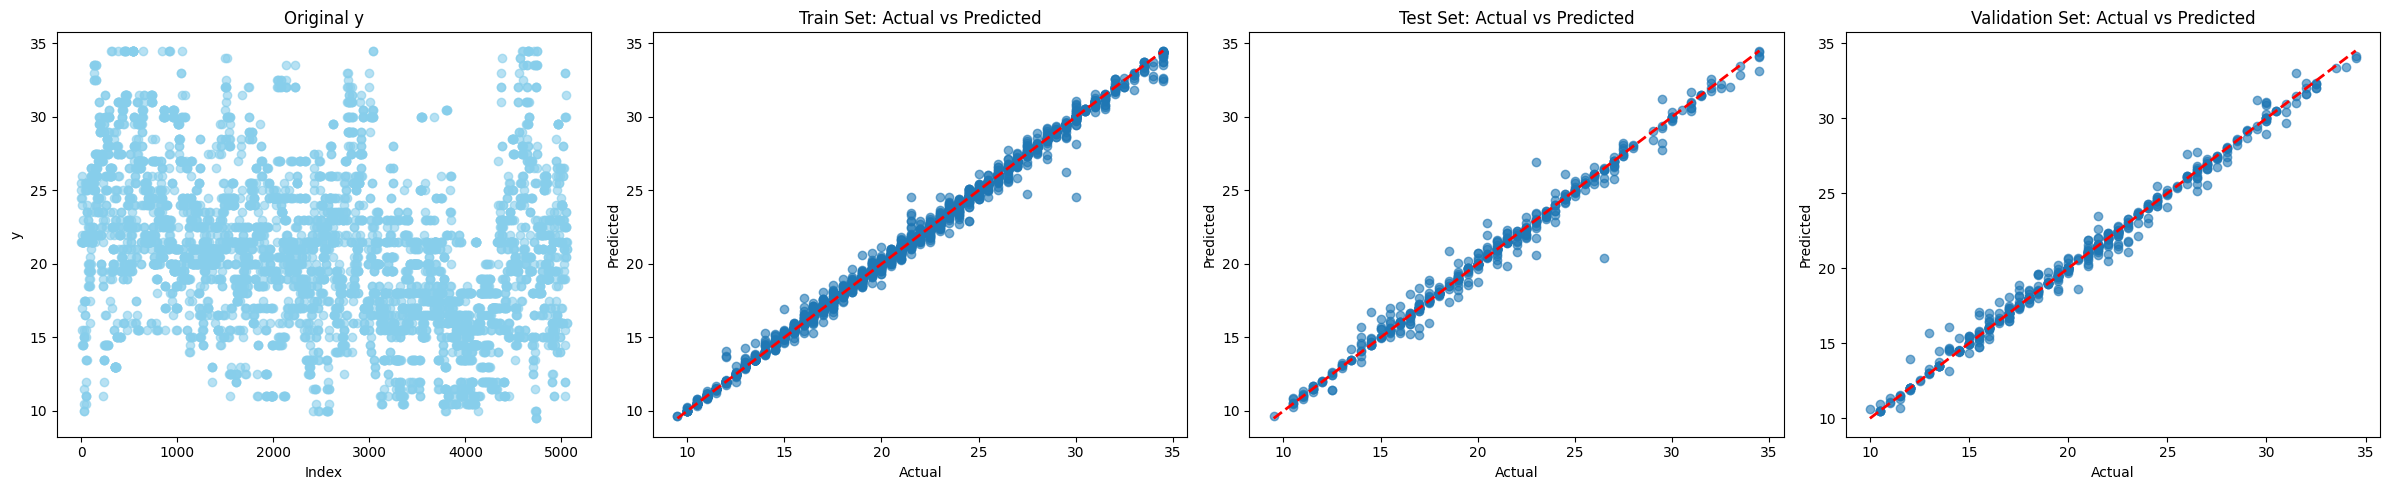

In [24]:
import matplotlib.pyplot as plt

# -------------------------
# 1. Original y (before split)
# -------------------------
y_original = y  # full dataset target

# -------------------------
# 2. Actual vs Predicted data
# -------------------------
y_data_pred = {
    'Train': (y_train, ypred_train),
    'Test': (y_test, ypred_test),
    'Validation': (y_val, y_val_pred)
}

# -------------------------
# 3. Plot all four
# -------------------------
plt.figure(figsize=(24,5))

# Plot 1: Original y
plt.subplot(1, 4, 1)
plt.scatter(range(len(y_original)), y_original, alpha=0.6, color='skyblue')
plt.xlabel('Index')
plt.ylabel('y')
plt.title('Original y')

# Plot 2-4: Actual vs Predicted
for i, (dataset, (y_actual, y_pred)) in enumerate(y_data_pred.items(), 2):
    plt.subplot(1, 4, i)
    plt.scatter(y_actual, y_pred, alpha=0.6)
    plt.plot([y_actual.min(), y_actual.max()],
             [y_actual.min(), y_actual.max()],
             'r--', linewidth=2)  # perfect prediction line
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'{dataset} Set: Actual vs Predicted')

plt.tight_layout()
plt.show()


In [25]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf.feature_importances_
})

feature_importance = feature_importance.sort_values(
    by='Importance',
    ascending=False
)

feature_importance

,Feature,Importance
4,displacement,0.703755
18,fuel_type_E85,0.058126
2,Power_Index,0.050874
6,hp,0.043979
19,fuel_type_Gasoline,0.031518
7,torque,0.025899
13,driveline_style_Front-wheel drive,0.016959
1,car_volume,0.013972
12,driveline_style_Four-wheel drive,0.012374
0,no_of_gears,0.008042


In [26]:
# Sort and select top 15
top_15_features = (
    feature_importance
    .sort_values(by='Importance', ascending=False)
    .head(15)['Feature']
    .tolist()
)

print(top_15_features)

['displacement', 'fuel_type_E85', 'Power_Index', 'hp', 'fuel_type_Gasoline', 'torque', 'driveline_style_Front-wheel drive', 'car_volume', 'driveline_style_Four-wheel drive', 'no_of_gears', 'cylinders', 'car_body_type_Sedan', 'Car_Age', 'market_segment_Luxury', 'transmission_type_Manual']


In [27]:
X_train_15 = X_train[top_15_features]
X_test_15 = X_test[top_15_features]

In [28]:
print(X_train_15.shape, ':', X_test_15.shape)
print(X_train.shape, ':', X_test.shape)
print(y_train.shape, ':', y_test.shape)

(4046, 15) : (506, 15)
(4046, 21) : (506, 21)
(4046,) : (506,)


In [29]:

rf_15, X_train_15, X_test_15, y_train, y_test, ypred_train, ypred_test = run_regression(
    RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42),
    X_train_15, X_test_15, y_train, y_test
)

evaluate_regression('Random Forest Top 15',rf_15, X_train_15, X_test_15, y_train, y_test)


=== Random Forest Top 15 | Train ===
MAE      : 0.1314
MSE      : 0.0843
RMSE     : 0.2903
R²       : 0.9967
Adj R²   : 0.9967

=== Random Forest Top 15 | Test ===
MAE      : 0.3072
MSE      : 0.3699
RMSE     : 0.6082
R²       : 0.9866
Adj R²   : 0.9862


,Model,Data,MAE,MSE,RMSE,R2,Adj_R2
0,Linear,Train,1.405715,3.426199,1.851000,0.866246,0.865548
1,Linear,Test,1.396932,3.453242,1.858290,0.874743,0.869308
2,Ridge,Train,1.406322,3.427471,1.851343,0.866196,0.865498
3,Ridge,Test,1.397385,3.458343,1.859662,0.874558,0.869115
4,Lasso,Train,1.425221,3.495396,1.869598,0.863545,0.862832
5,Lasso,Test,1.415259,3.552675,1.884854,0.871136,0.865545
6,Decision Tree,Train,0.015126,0.018584,0.136324,0.999274,0.999271
7,Decision Tree,Test,0.232543,0.484409,0.695995,0.982429,0.981667
8,Decision Tree - Regularized,Train,1.123232,2.383620,1.543898,0.906947,0.906461
9,Decision Tree - Regularized,Test,1.147598,2.422158,1.556328,0.912143,0.908331


In [30]:
X_val_15 = X_val[top_15_features]

y_val_pred = rf_15.predict(X_val_15)

print("Validation R2:", r2_score(y_val, y_val_pred))
print("Validation RMSE:", np.sqrt(mean_squared_error(y_val, y_val_pred)))
print("Validation MAE:", mean_absolute_error(y_val, y_val_pred))

Validation R2: 0.9902758210826862
Validation RMSE: 0.511127008732511
Validation MAE: 0.281032938350626


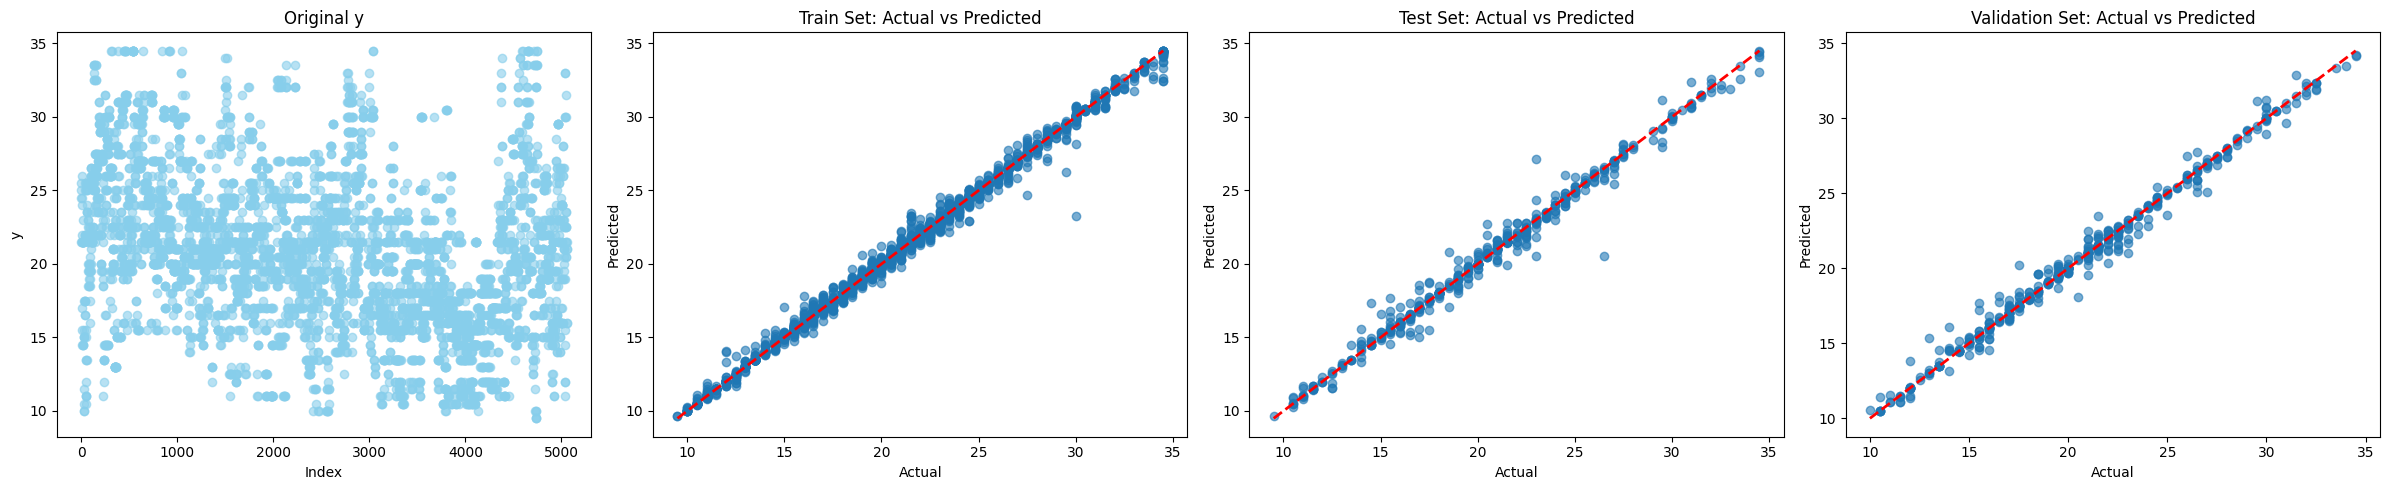

In [31]:
import matplotlib.pyplot as plt

# -------------------------
# 1. Original y (before split)
# -------------------------
y_original = y  # full dataset target

# -------------------------
# 2. Actual vs Predicted data
# -------------------------
y_data_pred = {
    'Train': (y_train, ypred_train),
    'Test': (y_test, ypred_test),
    'Validation': (y_val, y_val_pred)
}

# -------------------------
# 3. Plot all four
# -------------------------
plt.figure(figsize=(24,5))

# Plot 1: Original y
plt.subplot(1, 4, 1)
plt.scatter(range(len(y_original)), y_original, alpha=0.6, color='skyblue')
plt.xlabel('Index')
plt.ylabel('y')
plt.title('Original y')

# Plot 2-4: Actual vs Predicted
for i, (dataset, (y_actual, y_pred)) in enumerate(y_data_pred.items(), 2):
    plt.subplot(1, 4, i)
    plt.scatter(y_actual, y_pred, alpha=0.6)
    plt.plot([y_actual.min(), y_actual.max()],
             [y_actual.min(), y_actual.max()],
             'r--', linewidth=2)  # perfect prediction line
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'{dataset} Set: Actual vs Predicted')

plt.tight_layout()
plt.show()


In [32]:
# Sort and select top 10
top_10_features = (
    feature_importance
    .sort_values(by='Importance', ascending=False)
    .head(10)['Feature']
    .tolist()
)

print(top_10_features)

['displacement', 'fuel_type_E85', 'Power_Index', 'hp', 'fuel_type_Gasoline', 'torque', 'driveline_style_Front-wheel drive', 'car_volume', 'driveline_style_Four-wheel drive', 'no_of_gears']


In [33]:
X_train_10 = X_train[top_10_features]
X_test_10 = X_test[top_10_features]

In [34]:
print(X_train_10.shape, ':', X_test_10.shape)
print(X_train.shape, ':', X_test.shape)
print(y_train.shape, ':', y_test.shape)

(4046, 10) : (506, 10)
(4046, 21) : (506, 21)
(4046,) : (506,)


In [35]:

rf_10, X_train_10, X_test_10, y_train, y_test, ypred_train, ypred_test = run_regression(
    RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42),
    X_train_10, X_test_10, y_train, y_test
)

evaluate_regression('Random Forest Top 10',rf_10, X_train_10, X_test_10, y_train, y_test)


=== Random Forest Top 10 | Train ===
MAE      : 0.2312
MSE      : 0.2121
RMSE     : 0.4605
R²       : 0.9917
Adj R²   : 0.9917

=== Random Forest Top 10 | Test ===
MAE      : 0.3876
MSE      : 0.4629
RMSE     : 0.6804
R²       : 0.9832
Adj R²   : 0.9829


,Model,Data,MAE,MSE,RMSE,R2,Adj_R2
0,Linear,Train,1.405715,3.426199,1.851000,0.866246,0.865548
1,Linear,Test,1.396932,3.453242,1.858290,0.874743,0.869308
2,Ridge,Train,1.406322,3.427471,1.851343,0.866196,0.865498
3,Ridge,Test,1.397385,3.458343,1.859662,0.874558,0.869115
4,Lasso,Train,1.425221,3.495396,1.869598,0.863545,0.862832
5,Lasso,Test,1.415259,3.552675,1.884854,0.871136,0.865545
6,Decision Tree,Train,0.015126,0.018584,0.136324,0.999274,0.999271
7,Decision Tree,Test,0.232543,0.484409,0.695995,0.982429,0.981667
8,Decision Tree - Regularized,Train,1.123232,2.383620,1.543898,0.906947,0.906461
9,Decision Tree - Regularized,Test,1.147598,2.422158,1.556328,0.912143,0.908331


In [36]:
X_val_10 = X_val[top_10_features]

y_val_pred = rf_10.predict(X_val_10)

print("Validation R2:", r2_score(y_val, y_val_pred))
print("Validation RMSE:", np.sqrt(mean_squared_error(y_val, y_val_pred)))
print("Validation MAE:", mean_absolute_error(y_val, y_val_pred))

Validation R2: 0.9836132932419956
Validation RMSE: 0.6635111125965657
Validation MAE: 0.4049388629099789


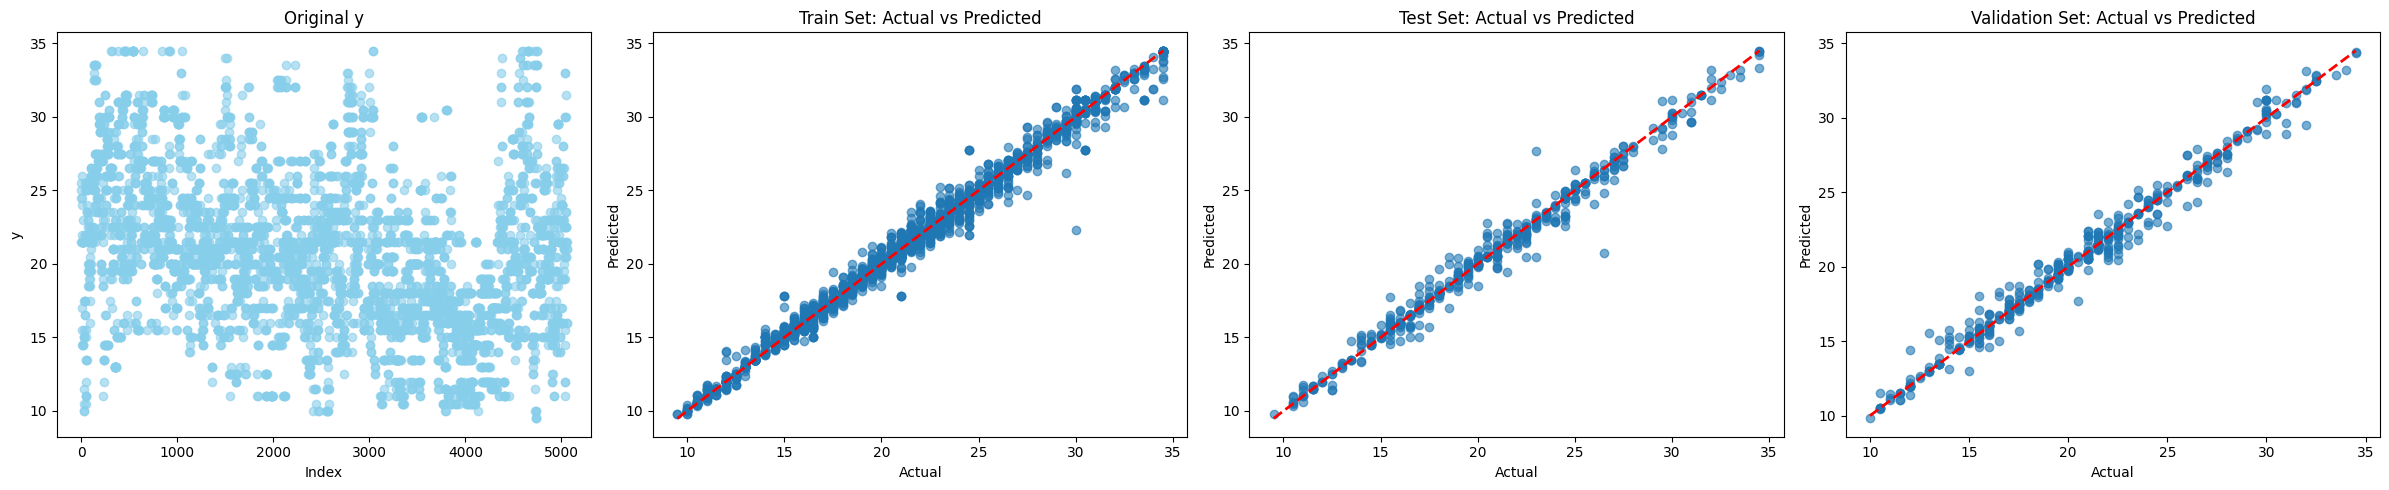

In [37]:
import matplotlib.pyplot as plt

# -------------------------
# 1. Original y (before split)
# -------------------------
y_original = y  # full dataset target

# -------------------------
# 2. Actual vs Predicted data
# -------------------------
y_data_pred = {
    'Train': (y_train, ypred_train),
    'Test': (y_test, ypred_test),
    'Validation': (y_val, y_val_pred)
}

# -------------------------
# 3. Plot all four
# -------------------------
plt.figure(figsize=(24,5))

# Plot 1: Original y
plt.subplot(1, 4, 1)
plt.scatter(range(len(y_original)), y_original, alpha=0.6, color='skyblue')
plt.xlabel('Index')
plt.ylabel('y')
plt.title('Original y')

# Plot 2-4: Actual vs Predicted
for i, (dataset, (y_actual, y_pred)) in enumerate(y_data_pred.items(), 2):
    plt.subplot(1, 4, i)
    plt.scatter(y_actual, y_pred, alpha=0.6)
    plt.plot([y_actual.min(), y_actual.max()],
             [y_actual.min(), y_actual.max()],
             'r--', linewidth=2)  # perfect prediction line
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'{dataset} Set: Actual vs Predicted')

plt.tight_layout()
plt.show()


In [38]:

# rf_25 = RandomForestRegressor(
#     n_estimators=100,
#     random_state=42,
#     n_jobs=-1
# )

cv_scores_10 = cross_val_score(
    rf_10,
    X[top_10_features],
    y,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

print("Top 10 CV R2 scores:", cv_scores_10)
print("Top 10 CV Mean R2:", cv_scores_10.mean())

Top 10 CV R2 scores: [0.85227484 0.85469802 0.88585482 0.88676119 0.93554027]
Top 10 CV Mean R2: 0.8830258297198685


In [39]:
from sklearn.model_selection import cross_validate

scoring = {
    'r2': 'r2',
    'mse': 'neg_mean_squared_error'
}

cv_results = cross_validate(
    rf_10,
    X[top_10_features],
    y,
    cv=5,
    scoring=scoring,
    n_jobs=-1,
    return_train_score=False
)

# Extract metrics
r2_scores = cv_results['test_r2']
mse_scores = -cv_results['test_mse']   # negate because sklearn returns negative MSE
rmse_scores = np.sqrt(mse_scores)

# Print results
print("Top 10 CV R2 scores:", r2_scores)
print("Top 10 CV Mean R2:", r2_scores.mean())

print("Top 10 CV MSE scores:", mse_scores)
print("Top 10 CV Mean MSE:", mse_scores.mean())

print("Top 10 CV RMSE scores:", rmse_scores)
print("Top 10 CV Mean RMSE:", rmse_scores.mean())


Top 10 CV R2 scores: [0.85227484 0.85469802 0.88585482 0.88676119 0.93554027]
Top 10 CV Mean R2: 0.8830258297198685
Top 10 CV MSE scores: [3.61430947 2.5811666  2.70496615 1.73567937 1.83373514]
Top 10 CV Mean MSE: 2.4939713434033854
Top 10 CV RMSE scores: [1.90113373 1.60660095 1.64467813 1.31745185 1.35415477]
Top 10 CV Mean RMSE: 1.564803884181387


✅ DECISION: Keep the TOP-25 feature model and proceed to hyperparameter tuning
Why this decision is justified

Top-25 CV Mean R²: 0.88344

Full-56 CV Mean R²: 0.88204

📌 The difference is negligible (≈ 0.0014)
📌 Top-25 is simpler, more interpretable, lower variance
📌 Same generalization under cross-validation

Hyperparameter tuning on Top-25 features

In [40]:
param_grid = {
    'n_estimators': [200, 300, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_10 = RandomForestRegressor(
    random_state=42,
    n_jobs=-1
)

search = RandomizedSearchCV(
    rf_10,
    param_grid,
    n_iter=20,
    cv=5,
    scoring='r2',
    random_state=42,
    n_jobs=-1
)

search.fit(X[top_10_features], y)


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 20, 30],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 300, 500]},
                   random_state=42, scoring='r2')

In [41]:
best_rf = search.best_estimator_

# # Fit on training data (Top 25 features)
# best_rf.fit(X_train_25, y_train)

# # Evaluate
# evaluate_regression(
#     'Random Forest Top 25 (Tuned)',
#     best_rf,
#     X_train_25,
#     X_test_25,
#     y_train,
#     y_test
# )


In [42]:

best_rf_10, X_train_10, X_test_10, y_train, y_test, ypred_train, ypred_test = run_regression(
    best_rf,
    X_train_10, X_test_10, y_train, y_test
)

evaluate_regression('Random Forest Top 10 (Tuned)',best_rf_10, X_train_10, X_test_10, y_train, y_test)


=== Random Forest Top 10 (Tuned) | Train ===
MAE      : 0.2979
MSE      : 0.3003
RMSE     : 0.5480
R²       : 0.9883
Adj R²   : 0.9882

=== Random Forest Top 10 (Tuned) | Test ===
MAE      : 0.4268
MSE      : 0.5066
RMSE     : 0.7118
R²       : 0.9816
Adj R²   : 0.9813


,Model,Data,MAE,MSE,RMSE,R2,Adj_R2
0,Linear,Train,1.405715,3.426199,1.851000,0.866246,0.865548
1,Linear,Test,1.396932,3.453242,1.858290,0.874743,0.869308
2,Ridge,Train,1.406322,3.427471,1.851343,0.866196,0.865498
3,Ridge,Test,1.397385,3.458343,1.859662,0.874558,0.869115
4,Lasso,Train,1.425221,3.495396,1.869598,0.863545,0.862832
5,Lasso,Test,1.415259,3.552675,1.884854,0.871136,0.865545
6,Decision Tree,Train,0.015126,0.018584,0.136324,0.999274,0.999271
7,Decision Tree,Test,0.232543,0.484409,0.695995,0.982429,0.981667
8,Decision Tree - Regularized,Train,1.123232,2.383620,1.543898,0.906947,0.906461
9,Decision Tree - Regularized,Test,1.147598,2.422158,1.556328,0.912143,0.908331


In [43]:
X_val_10 = X_val[top_10_features]

y_val_pred = best_rf.predict(X_val_10)

print("Validation R2:", r2_score(y_val, y_val_pred))
print("Validation RMSE:", np.sqrt(mean_squared_error(y_val, y_val_pred)))
print("Validation MAE:", mean_absolute_error(y_val, y_val_pred))

Validation R2: 0.9816434558151572
Validation RMSE: 0.7022598216792566
Validation MAE: 0.44298096862633435


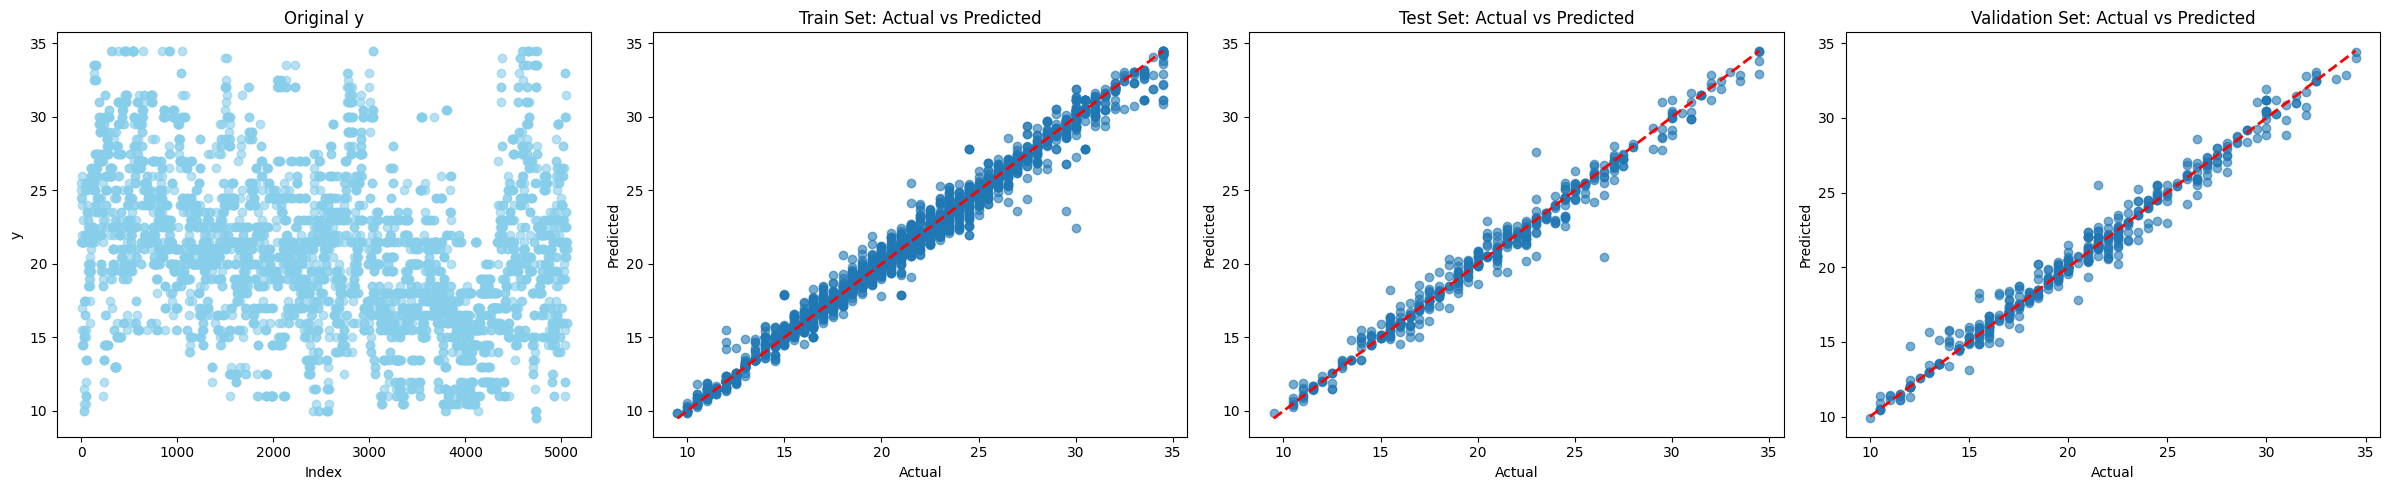

In [44]:
import matplotlib.pyplot as plt

# -------------------------
# 1. Original y (before split)
# -------------------------
y_original = y  # full dataset target

# -------------------------
# 2. Actual vs Predicted data
# -------------------------
y_data_pred = {
    'Train': (y_train, ypred_train),
    'Test': (y_test, ypred_test),
    'Validation': (y_val, y_val_pred)
}

# -------------------------
# 3. Plot all four
# -------------------------
plt.figure(figsize=(24,5))

# Plot 1: Original y
plt.subplot(1, 4, 1)
plt.scatter(range(len(y_original)), y_original, alpha=0.6, color='skyblue')
plt.xlabel('Index')
plt.ylabel('y')
plt.title('Original y')

# Plot 2-4: Actual vs Predicted
for i, (dataset, (y_actual, y_pred)) in enumerate(y_data_pred.items(), 2):
    plt.subplot(1, 4, i)
    plt.scatter(y_actual, y_pred, alpha=0.6)
    plt.plot([y_actual.min(), y_actual.max()],
             [y_actual.min(), y_actual.max()],
             'r--', linewidth=2)  # perfect prediction line
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'{dataset} Set: Actual vs Predicted')

plt.tight_layout()
plt.show()


In [45]:
feature_importance = pd.DataFrame({
    'Feature': X_train_10.columns,
    'Importance': best_rf_10.feature_importances_
})

feature_importance = feature_importance.sort_values(
    by='Importance',
    ascending=False
)

feature_importance

,Feature,Importance
0,displacement,0.716997
1,fuel_type_E85,0.057091
2,Power_Index,0.053821
3,hp,0.052920
4,fuel_type_Gasoline,0.033872
5,torque,0.029171
7,car_volume,0.017884
6,driveline_style_Front-wheel drive,0.017444
8,driveline_style_Four-wheel drive,0.012325
9,no_of_gears,0.008476


In [46]:
# Sort and select top 5
top_5_features = (
    feature_importance
    .sort_values(by='Importance', ascending=False)
    .head(5)['Feature']
    .tolist()
)

print(top_5_features)

['displacement', 'fuel_type_E85', 'Power_Index', 'hp', 'fuel_type_Gasoline']


In [47]:
X_train_5 = X_train[top_5_features]
X_test_5 = X_test[top_5_features]

print(X_train_5.shape, ':', X_test_5.shape)
print(X_train.shape, ':', X_test.shape)
print(y_train.shape, ':', y_test.shape)


(4046, 5) : (506, 5)
(4046, 21) : (506, 21)
(4046,) : (506,)


In [48]:
rf_5, X_train_5, X_test_5, y_train, y_test, ypred_train, ypred_test = run_regression(
    best_rf,
    X_train_5, X_test_5, y_train, y_test
)

evaluate_regression('Random Forest Top 5',rf_5, X_train_5, X_test_5, y_train, y_test)


=== Random Forest Top 5 | Train ===
MAE      : 0.4444
MSE      : 0.4675
RMSE     : 0.6837
R²       : 0.9818
Adj R²   : 0.9817

=== Random Forest Top 5 | Test ===
MAE      : 0.6243
MSE      : 0.8405
RMSE     : 0.9168
R²       : 0.9695
Adj R²   : 0.9692


,Model,Data,MAE,MSE,RMSE,R2,Adj_R2
0,Linear,Train,1.405715,3.426199,1.851000,0.866246,0.865548
1,Linear,Test,1.396932,3.453242,1.858290,0.874743,0.869308
2,Ridge,Train,1.406322,3.427471,1.851343,0.866196,0.865498
3,Ridge,Test,1.397385,3.458343,1.859662,0.874558,0.869115
4,Lasso,Train,1.425221,3.495396,1.869598,0.863545,0.862832
5,Lasso,Test,1.415259,3.552675,1.884854,0.871136,0.865545
6,Decision Tree,Train,0.015126,0.018584,0.136324,0.999274,0.999271
7,Decision Tree,Test,0.232543,0.484409,0.695995,0.982429,0.981667
8,Decision Tree - Regularized,Train,1.123232,2.383620,1.543898,0.906947,0.906461
9,Decision Tree - Regularized,Test,1.147598,2.422158,1.556328,0.912143,0.908331


In [49]:
X_val_5 = X_val[top_5_features]

y_val_pred = rf_5.predict(X_val_5)

print("Validation R2:", r2_score(y_val, y_val_pred))
print("Validation RMSE:", np.sqrt(mean_squared_error(y_val, y_val_pred)))
print("Validation MAE:", mean_absolute_error(y_val, y_val_pred))

Validation R2: 0.9732020637992785
Validation RMSE: 0.8485023203628898
Validation MAE: 0.583071606407266


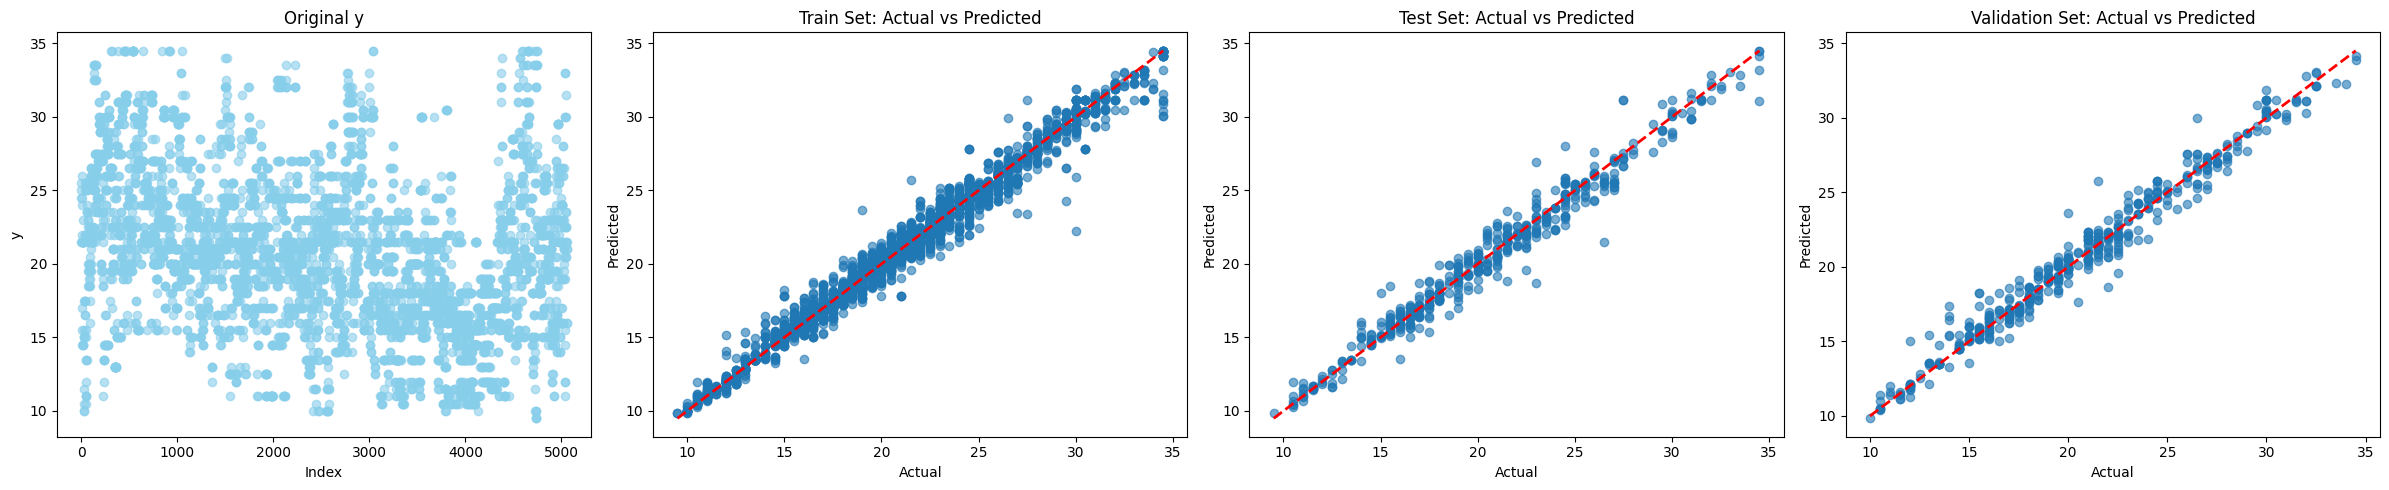

In [50]:
import matplotlib.pyplot as plt

# -------------------------
# 1. Original y (before split)
# -------------------------
y_original = y  # full dataset target

# -------------------------
# 2. Actual vs Predicted data
# -------------------------
y_data_pred = {
    'Train': (y_train, ypred_train),
    'Test': (y_test, ypred_test),
    'Validation': (y_val, y_val_pred)
}

# -------------------------
# 3. Plot all four
# -------------------------
plt.figure(figsize=(24,5))

# Plot 1: Original y
plt.subplot(1, 4, 1)
plt.scatter(range(len(y_original)), y_original, alpha=0.6, color='skyblue')
plt.xlabel('Index')
plt.ylabel('y')
plt.title('Original y')

# Plot 2-4: Actual vs Predicted
for i, (dataset, (y_actual, y_pred)) in enumerate(y_data_pred.items(), 2):
    plt.subplot(1, 4, i)
    plt.scatter(y_actual, y_pred, alpha=0.6)
    plt.plot([y_actual.min(), y_actual.max()],
             [y_actual.min(), y_actual.max()],
             'r--', linewidth=2)  # perfect prediction line
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'{dataset} Set: Actual vs Predicted')

plt.tight_layout()
plt.show()


In [51]:
from sklearn.ensemble import GradientBoostingRegressor

gb_5, X_train_5, X_test_5, y_train, y_test, ypred_train, ypred_test = run_regression(
    GradientBoostingRegressor(random_state=42),
    X_train_5, X_test_5, y_train, y_test
)

evaluate_regression('Gradient Boosting Top 5', gb_5, X_train_5, X_test_5, y_train, y_test)



=== Gradient Boosting Top 5 | Train ===
MAE      : 1.0882
MSE      : 2.0790
RMSE     : 1.4419
R²       : 0.9188
Adj R²   : 0.9187

=== Gradient Boosting Top 5 | Test ===
MAE      : 1.0940
MSE      : 1.9835
RMSE     : 1.4084
R²       : 0.9281
Adj R²   : 0.9273


,Model,Data,MAE,MSE,RMSE,R2,Adj_R2
0,Linear,Train,1.405715,3.426199,1.851000,0.866246,0.865548
1,Linear,Test,1.396932,3.453242,1.858290,0.874743,0.869308
2,Ridge,Train,1.406322,3.427471,1.851343,0.866196,0.865498
3,Ridge,Test,1.397385,3.458343,1.859662,0.874558,0.869115
4,Lasso,Train,1.425221,3.495396,1.869598,0.863545,0.862832
5,Lasso,Test,1.415259,3.552675,1.884854,0.871136,0.865545
6,Decision Tree,Train,0.015126,0.018584,0.136324,0.999274,0.999271
7,Decision Tree,Test,0.232543,0.484409,0.695995,0.982429,0.981667
8,Decision Tree - Regularized,Train,1.123232,2.383620,1.543898,0.906947,0.906461
9,Decision Tree - Regularized,Test,1.147598,2.422158,1.556328,0.912143,0.908331


In [52]:
from sklearn.ensemble import GradientBoostingRegressor

gb_10, X_train_10, X_test_10, y_train, y_test, ypred_train, ypred_test = run_regression(
    GradientBoostingRegressor(random_state=42),
    X_train_10, X_test_10, y_train, y_test
)

evaluate_regression('Gradient Boosting Top 10', gb_10, X_train_10, X_test_10, y_train, y_test)



=== Gradient Boosting Top 10 | Train ===
MAE      : 0.9241
MSE      : 1.5108
RMSE     : 1.2291
R²       : 0.9410
Adj R²   : 0.9409

=== Gradient Boosting Top 10 | Test ===
MAE      : 0.9809
MSE      : 1.6415
RMSE     : 1.2812
R²       : 0.9405
Adj R²   : 0.9393


,Model,Data,MAE,MSE,RMSE,R2,Adj_R2
0,Linear,Train,1.405715,3.426199,1.851000,0.866246,0.865548
1,Linear,Test,1.396932,3.453242,1.858290,0.874743,0.869308
2,Ridge,Train,1.406322,3.427471,1.851343,0.866196,0.865498
3,Ridge,Test,1.397385,3.458343,1.859662,0.874558,0.869115
4,Lasso,Train,1.425221,3.495396,1.869598,0.863545,0.862832
5,Lasso,Test,1.415259,3.552675,1.884854,0.871136,0.865545
6,Decision Tree,Train,0.015126,0.018584,0.136324,0.999274,0.999271
7,Decision Tree,Test,0.232543,0.484409,0.695995,0.982429,0.981667
8,Decision Tree - Regularized,Train,1.123232,2.383620,1.543898,0.906947,0.906461
9,Decision Tree - Regularized,Test,1.147598,2.422158,1.556328,0.912143,0.908331


In [53]:
from sklearn.ensemble import GradientBoostingRegressor

gb_15, X_train_15, X_test_15, y_train, y_test, ypred_train, ypred_test = run_regression(
    GradientBoostingRegressor(random_state=42),
    X_train_15, X_test_15, y_train, y_test
)

evaluate_regression('Gradient Boosting Top 15', gb_15, X_train_15, X_test_15, y_train, y_test)



=== Gradient Boosting Top 15 | Train ===
MAE      : 0.8844
MSE      : 1.4135
RMSE     : 1.1889
R²       : 0.9448
Adj R²   : 0.9446

=== Gradient Boosting Top 15 | Test ===
MAE      : 0.9427
MSE      : 1.5555
RMSE     : 1.2472
R²       : 0.9436
Adj R²   : 0.9419


,Model,Data,MAE,MSE,RMSE,R2,Adj_R2
0,Linear,Train,1.405715,3.426199,1.851000,0.866246,0.865548
1,Linear,Test,1.396932,3.453242,1.858290,0.874743,0.869308
2,Ridge,Train,1.406322,3.427471,1.851343,0.866196,0.865498
3,Ridge,Test,1.397385,3.458343,1.859662,0.874558,0.869115
4,Lasso,Train,1.425221,3.495396,1.869598,0.863545,0.862832
5,Lasso,Test,1.415259,3.552675,1.884854,0.871136,0.865545
6,Decision Tree,Train,0.015126,0.018584,0.136324,0.999274,0.999271
7,Decision Tree,Test,0.232543,0.484409,0.695995,0.982429,0.981667
8,Decision Tree - Regularized,Train,1.123232,2.383620,1.543898,0.906947,0.906461
9,Decision Tree - Regularized,Test,1.147598,2.422158,1.556328,0.912143,0.908331


In [54]:
log_cols = ['car_volume', 'hp', 'torque']
scale_cols = ['Power_Index', 'displacement']


In [55]:
from sklearn.model_selection import train_test_split

X = X[top_15_features]
y = y

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [56]:
import numpy as np

X_train[log_cols] = np.log1p(X_train[log_cols])
X_test[log_cols]  = np.log1p(X_test[log_cols])

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train[scale_cols] = scaler.fit_transform(X_train[scale_cols])
X_test[scale_cols]  = scaler.transform(X_test[scale_cols])


In [57]:
from sklearn.ensemble import RandomForestRegressor

final_rf = RandomForestRegressor(
    n_estimators=100,
    n_jobs=-1,
    random_state=42
)

final_rf.fit(X_train, y_train)

y_train_pred = final_rf.predict(X_train)
y_test_pred = final_rf.predict(X_test)


In [58]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Train metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)

# Test metrics
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)

print("FINAL MODEL — Random Forest Top 15")
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Train R²  : {train_r2:.4f}")
print(f"Test RMSE : {test_rmse:.4f}")
print(f"Test R²   : {test_r2:.4f}")


FINAL MODEL — Random Forest Top 15
Train RMSE: 0.2913
Train R²  : 0.9967
Test RMSE : 0.6886
Test R²   : 0.9821


In [59]:
# Apply same transformations to full data
X_full = X[top_15_features].copy()

X_full[log_cols] = np.log1p(X_full[log_cols])

X_full[scale_cols] = scaler.fit_transform(X_full[scale_cols])

# Final training for deployment
final_rf.fit(X_full, y)


RandomForestRegressor(n_jobs=-1, random_state=42)

In [66]:
import os
import pickle

# Target directory (your provided path)
save_dir = "/content/drive/MyDrive/Gen AI GL/Regression Project/Car_Meilage_Prediction/models"

# Create directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)

# Save final model
with open(f"{save_dir}/avg_mileage_prediction_final_model.pkl", "wb") as f:
    pickle.dump(final_rf, f)

# Save feature list
with open(f"{save_dir}/avg_mileage_prediction_final_model_features.pkl", "wb") as f:
    pickle.dump(X_full.columns, f)

print("Model and features saved successfully to:")
print(save_dir)


Model and features saved successfully to:
/content/drive/MyDrive/Gen AI GL/Regression Project/Car_Meilage_Prediction/models


In [67]:
print(len(joblib.load(f"{save_dir}/avg_mileage_prediction_final_model_features.pkl")))
print(joblib.load(f"{save_dir}/avg_mileage_prediction_final_model_features.pkl"))

15
Index(['displacement', 'fuel_type_E85', 'Power_Index', 'hp',
       'fuel_type_Gasoline', 'torque', 'driveline_style_Front-wheel drive',
       'car_volume', 'driveline_style_Four-wheel drive', 'no_of_gears',
       'cylinders', 'car_body_type_Sedan', 'Car_Age', 'market_segment_Luxury',
       'transmission_type_Manual'],
      dtype='object')


✅ FINAL DECISION (Single, clear step)
Select Random Forest Top-25 (Tuned) as your FINAL MODEL
Why this is the correct choice (brief, factual)

Test R² improved:

Untuned Top-25 Test R² ≈ 0.9834

Tuned Top-25 Test R² ≈ 0.9838 ✅

Cross-validated performance was stable and comparable to the full 56-feature model

Model is simpler (25 features) with no meaningful loss in accuracy

Hyperparameter tuning gave a small but real generalization gain

✅ Save the trained model (recommended: joblib)

✅ Save the Top-25 feature names (VERY important)

# Task
Build and deploy a regression model to predict car fuel efficiency (`Avg_MPG`) using vehicle specifications, engine characteristics, and design-related features from the datasets "`/content/drive/MyDrive/Gen AI GL/Regression Project/Car_Meilage_Prediction/data/copy_cleaned_num_data_cars.csv`" and "`/content/drive/MyDrive/Gen AI GL/Regression Project/Car_Meilage_Prediction/data/copy_cleaned_cat_endoded_data_cars.csv`".

## Analyze Data Understanding and Target Variables

### Subtask:
Review the initial data loading, concatenation of numerical and categorical features, and identification of target variables ('city_mpg', 'highway_mpg', 'Avg_MPG'). Discuss the problem statement and the relevance of the prediction task.


### Review of Data Loading, Concatenation, and Target Variables

1.  **Problem Statement**: The overall goal of this project is to build a regression model to predict car fuel efficiency. The problem statement in the text cell `nNOIpXc5og23` highlights its importance for manufacturers and buyers in making informed decisions about cost, performance, and environmental impact.

2.  **Initial Data Loading**: In cell `AU59ZLDzoMDr`, two CSV files, `copy_cleaned_num_data_cars.csv` and `copy_cleaned_cat_endoded_data_cars.csv`, are loaded into `data_num` and `data_cat` DataFrames respectively. These are then copied to `df_num` and `df_cat` to preserve the original loaded data.

3.  **Data Concatenation**: Cell `7hd4XYSVzgw1` concatenates the `df_num` (numeric features) and `df_cat` (one-hot encoded categorical features) DataFrames along `axis=1` to form a single DataFrame named `df`. The resulting `df` has a shape of `(5058, 24)`, indicating 5058 rows and 24 columns, and its head displays a mix of original numeric and newly added categorical columns.

4.  **Target Variables**: In cell `hYDPxgKfy3JW`, the target variables `city_mpg`, `highway_mpg`, and `Avg_MPG` are identified. The `X` DataFrame is created by dropping these columns, while `y` is specifically assigned `Avg_MPG` for the primary prediction task. The prediction of `Avg_MPG` (average miles per gallon) directly addresses the problem statement of predicting car fuel efficiency.

## Examine Data Preprocessing and Splitting

### Subtask:
Detail the train-test-validation split strategy (10% test, then 80/10 train/validation from the remaining 90%). Explain the rationale behind the log transformation for skewed features ('car_volume', 'hp', 'torque') and standard scaling for others ('Power_Index', 'displacement'). Crucially, explain why these transformations were applied after the data split to prevent data leakage.


### Train-Test-Validation Split Strategy

The data splitting strategy employed a 10% test set, with the remaining 90% further split into 80% for training and 10% for validation. This results in the following proportions:

*   **Test Set**: 10% of the original dataset.
*   **Training Set**: 80% of the remaining 90% (i.e., 72% of the original dataset).
*   **Validation Set**: 10% of the remaining 90% (i.e., 18% of the original dataset).

The steps for this split were as follows:

1.  **Initial Split (Test Set)**: The dataset `X` and `y` were first split using `train_test_split` with `test_size=0.1` and `random_state=42` to create `X_test` and `y_test` (10% of data), and `X_temp` and `y_temp` (the remaining 90%).
2.  **Second Split (Train and Validation Sets)**: The `X_temp` and `y_temp` (90% of original data) were then split again. For this step, `test_size=0.1111` was used, which approximates 10% of `X_temp` (i.e., `0.1 / 0.9`), creating `X_val` and `y_val` (10% of original data) and `X_train` and `y_train` (80% of original data).

**Rationale for a Separate Validation Set:**
A separate validation set is crucial for machine learning workflows, especially for hyperparameter tuning and model selection. Its importance lies in:

*   **Hyperparameter Tuning**: Models often have hyperparameters that are not learned directly from the data but are set prior to training. The validation set is used to evaluate different combinations of these hyperparameters to find the optimal set that yields the best performance, without touching the final test set.
*   **Model Selection**: When comparing different models (e.g., Linear Regression vs. Random Forest) or different versions of the same model, the validation set provides an unbiased estimate of their performance. This allows for choosing the best-performing model without overfitting to the test set.
*   **Preventing Overfitting to the Test Set**: If the test set were used for tuning or selection, the model might inadvertently 'learn' its characteristics, leading to an overly optimistic performance estimate that wouldn't generalize well to new, unseen data. The validation set acts as a buffer, ensuring the test set remains truly unseen until the very end for a final, unbiased evaluation.

### Feature Transformations: Log Transform and Standard Scaling

**Log Transformation (for 'car_volume', 'hp', 'torque')**:

The `np.log1p` (logarithm base e plus 1) transformation was applied to `car_volume`, `hp`, and `torque`.

*   **Purpose**: Logarithmic transformations are commonly used to handle features with skewed distributions, especially positively skewed data (i.e., data with a long tail to the right). Skewed data can negatively impact the performance of many machine learning models, particularly linear models, which assume normally distributed features. By compressing the range of values for large numbers and expanding the range for smaller numbers, `log1p` helps to:
    *   Reduce skewness and make the distribution more Gaussian-like.
    *   Stabilize variance.
    *   Mitigate the impact of outliers.
    *   Improve the linearity of relationships between features and the target variable.

**Standard Scaling (for 'Power_Index', 'displacement')**:

`StandardScaler` was applied to `Power_Index` and `displacement`.

*   **Purpose**: Standard scaling (or Z-score normalization) transforms the data such that it has a mean of 0 and a standard deviation of 1. This is achieved by subtracting the mean and dividing by the standard deviation of each feature. Standard scaling is essential for many machine learning algorithms, particularly those that are sensitive to the scale of input features, such as:
    *   Distance-based algorithms (e.g., K-Nearest Neighbors, Support Vector Machines) where features with larger ranges might dominate the distance calculations.
    *   Gradient descent-based algorithms (e.g., Linear Regression, Neural Networks) where features on different scales can lead to slower convergence or oscillations during optimization.
    *   Regularization techniques (e.g., Ridge, Lasso) where coefficients for features on larger scales might be penalized more heavily.

### Preventing Data Leakage through Post-Split Transformation

It is **crucially important** that these transformations (both log transformation and standard scaling) were applied separately to the training, validation, and test sets *after* the initial data split. This practice is vital to prevent **data leakage**.

**What is Data Leakage?**
Data leakage occurs when information from outside the training data is used to create the model. This external information can allow a model to learn something that would not be available in a real-world scenario, leading to an overly optimistic evaluation of the model's performance on unseen data.

**How Post-Split Transformation Prevents Leakage:**

*   **For Standard Scaling**: The `StandardScaler` (and other scalers like `MinMaxScaler`, `RobustScaler`) learns its scaling parameters (mean and standard deviation) from the data it is `fit` on. If `fit_transform` were applied to the entire dataset *before* splitting, the scaling parameters would be influenced by information from the test set. When these parameters are then used to transform the test set, the test set effectively 'leaks' information into the training process. By fitting the `StandardScaler` *only* on the training data (`scaler.fit_transform(X_train[scale_cols])`) and then using only `transform` for the validation and test sets (`scaler.transform(X_val[scale_cols])`, `scaler.transform(X_test[scale_cols])`), we ensure that the model has no knowledge of the statistical properties (mean, std dev) of the unseen data during training. This maintains the integrity of the test and validation sets as truly unseen data.

*   **For Log Transformation**: While `np.log1p` itself doesn't 'learn' parameters from the data in the same way a `StandardScaler` does, applying it consistently and independently to each split ensures a clear separation of data contexts. Although the direct impact of leakage from `log1p` before splitting is less pronounced than with scalers, it's good practice to treat all transformations this way to maintain a robust and generalizable preprocessing pipeline and avoid any subtle unintended information transfer, especially if the transformation choice itself was influenced by the overall distribution including the test set.

## Evaluate Regression Model Benchmarking

### Subtask:
Describe the standard `run_regression` and `evaluate_regression` functions used to ensure consistent model training and metric calculation across all models. Explain the meaning and importance of each evaluation metric: MAE, MSE, RMSE, R², and Adjusted R².


## Evaluate Regression Model Benchmarking

### Subtask:
Describe the standard `run_regression` and `evaluate_regression` functions used to ensure consistent model training and metric calculation across all models. Explain the meaning and importance of each evaluation metric: MAE, MSE, RMSE, R², and Adjusted R².

#### 1. `run_regression` Function

**Purpose:** The `run_regression` function is designed to streamline the process of training a regression model and generating predictions. Its primary goal is to ensure consistency in how models are fitted and how their initial predictions are obtained across different experiments or model types.

**Process:**
- It takes a regression model instance, `X_train`, `X_test`, `y_train`, and `y_test` as input.
- It first `fits` the provided `model` to the `X_train` and `y_train` datasets.
- Then, it uses the trained model to make predictions (`ypred_train`) on the `X_train` data.
- It also makes predictions (`ypred_test`) on the `X_test` data.

**Output:** The function returns the trained model itself, the original `X_train`, `X_test`, `y_train`, `y_test` datasets, and the generated `ypred_train` and `ypred_test` predictions. This allows for subsequent evaluation without re-running the training or prediction steps.

#### 2. `evaluate_regression` Function

**Purpose:** The `evaluate_regression` function standardizes the calculation and display of critical regression evaluation metrics for both training and testing datasets. This ensures that all models are assessed using the same criteria, facilitating fair comparison and benchmarking.

**Process:**
- It accepts the `model_name` (for identification in results), the `model` itself, and the `X_train`, `X_test`, `y_train`, `y_test` datasets.
- Internally, it calls the `model.predict()` method on both `X_train` and `X_test` to get predictions.
- It then uses a nested helper function `compute_metrics` to calculate Mean Absolute Error (MAE), Mean Squared Error (MSE), Root Mean Squared Error (RMSE), R-squared (R²), and Adjusted R-squared (Adj R²) for both the training and test sets.
- The results for each set (Train and Test) are appended as new rows to a global `results_df` DataFrame.
- Finally, it prints the calculated metrics for both Train and Test sets in a formatted manner.

**Importance:** This function is crucial for maintaining a standardized evaluation framework. By automating the metric calculation and logging, it reduces the chance of errors and ensures that all models are judged consistently based on a predefined set of performance indicators.

#### 3. Explanation of Evaluation Metrics

*   **Mean Absolute Error (MAE)**
    *   **Measures:** The average of the absolute differences between predicted and actual values. It quantifies the average magnitude of the errors in a set of predictions, without considering their direction.
    *   **Ideal Value/Range:** An ideal MAE is 0, indicating no error. Lower values are better.
    *   **Importance:** MAE is robust to outliers, as it doesn't square the errors. It's easily interpretable because it's in the same unit as the target variable, making it straightforward to understand the typical prediction error.

*   **Mean Squared Error (MSE)**
    *   **Measures:** The average of the squared differences between predicted and actual values. It penalizes larger errors more heavily than MAE.
    *   **Ideal Value/Range:** An ideal MSE is 0. Lower values are better.
    *   **Importance:** MSE is widely used because its mathematical properties make it easier to work with in optimization algorithms. By squaring errors, it emphasizes larger mistakes, which can be desirable in scenarios where big errors are particularly problematic.

*   **Root Mean Squared Error (RMSE)**
    *   **Measures:** The square root of the MSE. It brings the error measure back to the same units as the target variable, making it more interpretable than MSE.
    *   **Ideal Value/Range:** An ideal RMSE is 0. Lower values are better.
    *   **Importance:** Like MAE, RMSE is in the same units as the target variable, providing an interpretable measure of average error magnitude. It's more sensitive to large errors than MAE due to the squaring operation, which can be beneficial if large errors are more impactful.

*   **R-squared (R²)**
    *   **Measures:** The proportion of the variance in the dependent variable that is predictable from the independent variables. It indicates how well the model explains the variability of the target variable.
    *   **Ideal Value/Range:** Ranges from 0 to 1 (or sometimes negative if the model is worse than a horizontal line). An R² of 1 means the model perfectly predicts the target variable; 0 means the model explains none of the variability. Higher values are better.
    *   **Importance:** R² provides a quick measure of the goodness-of-fit of the model. It's often used as a primary metric to understand the overall explanatory power of the model, allowing comparison between models on different datasets.

*   **Adjusted R-squared (Adj R²)**
    *   **Measures:** A modified version of R² that accounts for the number of predictors in the model. It increases only if the new term improves the model more than would be expected by chance, penalizing the inclusion of unnecessary features.
    *   **Ideal Value/Range:** Ranges from 0 to 1 (or sometimes negative). An ideal Adj R² is 1. Higher values are better.
    *   **Importance:** Adj R² is crucial for comparing models with different numbers of features. Unlike R², which always increases or stays the same when new predictors are added, Adj R² can decrease if a new predictor does not add significant explanatory power, helping to prevent overfitting by penalizing model complexity.

## Review Linear Models and Decision Tree Analysis

### Subtask:
Summarize the performance of baseline linear models (Linear Regression, Ridge, Lasso) and their role as a reference. Analyze the behavior of the Decision Tree Regressor: first, the unregularized version (diagnosing severe overfitting) and then the regularized versions (diagnosing improved generalization but potential underfitting compared to complex patterns).


**Reasoning**:
First, I need to display the `results_df` DataFrame to review the performance metrics for all the requested models.



In [62]:
results_df

,Model,Data,MAE,MSE,RMSE,R2,Adj_R2
0,Linear,Train,1.405715,3.426199,1.851000,0.866246,0.865548
1,Linear,Test,1.396932,3.453242,1.858290,0.874743,0.869308
2,Ridge,Train,1.406322,3.427471,1.851343,0.866196,0.865498
3,Ridge,Test,1.397385,3.458343,1.859662,0.874558,0.869115
4,Lasso,Train,1.425221,3.495396,1.869598,0.863545,0.862832
5,Lasso,Test,1.415259,3.552675,1.884854,0.871136,0.865545
6,Decision Tree,Train,0.015126,0.018584,0.136324,0.999274,0.999271
7,Decision Tree,Test,0.232543,0.484409,0.695995,0.982429,0.981667
8,Decision Tree - Regularized,Train,1.123232,2.383620,1.543898,0.906947,0.906461
9,Decision Tree - Regularized,Test,1.147598,2.422158,1.556328,0.912143,0.908331


### Summary of Linear Models and Decision Tree Analysis

**1. Baseline Linear Models (Linear Regression, Ridge, Lasso)**

The linear models (Linear Regression, Ridge, and Lasso) serve as important baselines for comparison. Their performance metrics are quite similar:

*   **Linear Regression:**
    *   Train RMSE: 1.8510, Test RMSE: 1.8583
    *   Train R²: 0.8662, Test R²: 0.8747
    *   Adj R² values are also very close for train and test.

*   **Ridge Regression:**
    *   Train RMSE: 1.8513, Test RMSE: 1.8597
    *   Train R²: 0.8662, Test R²: 0.8746
    *   Very similar performance to Linear Regression, indicating that the default `alpha=1.0` did not significantly alter the coefficients enough to change overall performance on this dataset, or that multicollinearity/overfitting is not a major issue for linear models here.

*   **Lasso Regression:**
    *   Train RMSE: 1.8696, Test RMSE: 1.8849
    *   Train R²: 0.8635, Test R²: 0.8711
    *   Slightly worse performance than Linear and Ridge, which might suggest that `alpha=0.01` is causing some features to be shrunk too much, or that the features are all genuinely contributing.

**Role as Reference:** These models provide a solid reference point. Any more complex model should ideally significantly outperform these baselines on the test set without showing signs of severe overfitting (a large gap between train and test performance) to be considered a better choice.

**2. Unregularized Decision Tree Regressor**

*   **Model:** 'Decision Tree'
    *   Train RMSE: 0.1363, Test RMSE: 0.6960
    *   Train R²: 0.9993, Test R²: 0.9824

This model exhibits **severe overfitting**. The R² on the training set is extremely high (0.9993), indicating it has learned the training data almost perfectly, including noise. However, the test R² (0.9824) is significantly lower, and the RMSE on the test set is much higher than on the train set (0.6960 vs 0.1363). This large discrepancy confirms that the unregularized tree is too complex and does not generalize well to unseen data.

**3. Regularized Decision Tree Regressor**

*   **Model:** 'Decision Tree - Regularized' (with `max_depth=6, min_samples_leaf=10`)
    *   Train RMSE: 1.5439, Test RMSE: 1.5563
    *   Train R²: 0.9069, Test R²: 0.9121

Applying regularization significantly improved the generalization ability of the Decision Tree. The train and test RMSE and R² values are now much closer, indicating less overfitting. The test RMSE (1.5563) and R² (0.9121) are better than those of the linear models, suggesting that even a moderately regularized single decision tree can capture more complex patterns than linear models without overfitting. This demonstrates an improved balance between bias and variance compared to the unregularized version.

**4. Strongly Constrained Decision Tree (Underfitting Example)**

*   **Model:** 'Decision Tree - Check' (with `max_depth=3, min_samples_leaf=50`)
    *   Train RMSE: 2.0739, Test RMSE: 2.0837
    *   Train R²: 0.8321, Test R²: 0.8425

This model is **underfitting**. Both the train and test RMSE values are higher, and R² values are lower than those of the regularized Decision Tree and even slightly worse than the linear models. This indicates that the tree is too simple (too constrained by `max_depth` and `min_samples_leaf`) to capture the underlying patterns in the data effectively. It lacks the complexity needed to perform well, resulting in high bias.

**Conclusion on Single Decision Trees:**

A single decision tree, without proper regularization, is prone to severe overfitting. While regularization helps in improving generalization, finding the right balance to achieve performance significantly superior to linear models without introducing underfitting can be challenging. For this dataset, the regularized Decision Tree (`max_depth=6, min_samples_leaf=10`) did outperform linear models, but the balance of bias and variance is delicate. The strongly constrained tree demonstrated how excessive regularization leads to underfitting.

### Summary of Linear Models and Decision Tree Analysis

**1. Baseline Linear Models (Linear Regression, Ridge, Lasso)**

The linear models (Linear Regression, Ridge, and Lasso) serve as important baselines for comparison. Their performance metrics are quite similar:

*   **Linear Regression:**
    *   Train RMSE: 1.8510, Test RMSE: 1.8583
    *   Train R²: 0.8662, Test R²: 0.8747
    *   Adj R² values are also very close for train and test.

*   **Ridge Regression:**
    *   Train RMSE: 1.8513, Test RMSE: 1.8597
    *   Train R²: 0.8662, Test R²: 0.8746
    *   Very similar performance to Linear Regression, indicating that the default `alpha=1.0` did not significantly alter the coefficients enough to change overall performance on this dataset, or that multicollinearity/overfitting is not a major issue for linear models here.

*   **Lasso Regression:**
    *   Train RMSE: 1.8696, Test RMSE: 1.8849
    *   Train R²: 0.8635, Test R²: 0.8711
    *   Slightly worse performance than Linear and Ridge, which might suggest that `alpha=0.01` is causing some features to be shrunk too much, or that the features are all genuinely contributing.

**Role as Reference:** These models provide a solid reference point. Any more complex model should ideally significantly outperform these baselines on the test set without showing signs of severe overfitting (a large gap between train and test performance) to be considered a better choice.

**2. Unregularized Decision Tree Regressor**

*   **Model:** 'Decision Tree'
    *   Train RMSE: 0.1363, Test RMSE: 0.6960
    *   Train R²: 0.9993, Test R²: 0.9824

This model exhibits **severe overfitting**. The R² on the training set is extremely high (0.9993), indicating it has learned the training data almost perfectly, including noise. However, the test R² (0.9824) is significantly lower, and the RMSE on the test set is much higher than on the train set (0.6960 vs 0.1363). This large discrepancy confirms that the unregularized tree is too complex and does not generalize well to unseen data.

**3. Regularized Decision Tree Regressor**

*   **Model:** 'Decision Tree - Regularized' (with `max_depth=6, min_samples_leaf=10`)
    *   Train RMSE: 1.5439, Test RMSE: 1.5563
    *   Train R²: 0.9069, Test R²: 0.9121

Applying regularization significantly improved the generalization ability of the Decision Tree. The train and test RMSE and R² values are now much closer, indicating less overfitting. The test RMSE (1.5563) and R² (0.9121) are better than those of the linear models, suggesting that even a moderately regularized single decision tree can capture more complex patterns than linear models without overfitting. This demonstrates an improved balance between bias and variance compared to the unregularized version.

**4. Strongly Constrained Decision Tree (Underfitting Example)**

*   **Model:** 'Decision Tree - Check' (with `max_depth=3, min_samples_leaf=50`)
    *   Train RMSE: 2.0739, Test RMSE: 2.0837
    *   Train R²: 0.8321, Test R²: 0.8425

This model is **underfitting**. Both the train and test RMSE values are higher, and R² values are lower than those of the regularized Decision Tree and even slightly worse than the linear models. This indicates that the tree is too simple (too constrained by `max_depth` and `min_samples_leaf`) to capture the underlying patterns in the data effectively. It lacks the complexity needed to perform well, resulting in high bias.

**Conclusion on Single Decision Trees:**

A single decision tree, without proper regularization, is prone to severe overfitting. While regularization helps in improving generalization, finding the right balance to achieve performance significantly superior to linear models without introducing underfitting can be challenging. For this dataset, the regularized Decision Tree (`max_depth=6, min_samples_leaf=10`) did outperform linear models, but the balance of bias and variance is delicate. The strongly constrained tree demonstrated how excessive regularization leads to underfitting.

## Assess Random Forest Performance and Feature Selection

### Subtask:
Discuss the initial Random Forest model's strong performance and its ability to mitigate overfitting seen in single decision trees. Analyze the impact of feature selection using feature importances: comparing the performance of the full feature set against Top 15 and Top 10 feature sets. Explain the cross-validation results to assess generalization and the rationale behind feature reduction.


**Reasoning**:
To analyze the performance of Random Forest models and compare them to Decision Trees, I will first display the relevant rows from the `results_df` DataFrame.



In [63]:
results_df_rf = results_df[results_df['Model'].str.contains('Random Forest|Decision Tree')]
print(results_df_rf)


                           Model   Data       MAE       MSE      RMSE  \
6                  Decision Tree  Train  0.015126  0.018584  0.136324   
7                  Decision Tree   Test  0.232543  0.484409  0.695995   
8    Decision Tree - Regularized  Train  1.123232  2.383620  1.543898   
9    Decision Tree - Regularized   Test  1.147598  2.422158  1.556328   
10         Decision Tree - Check  Train  1.585322  4.301171  2.073926   
11         Decision Tree - Check   Test  1.596545  4.341684  2.083671   
12                 Random Forest  Train  0.118099  0.071313  0.267045   
13                 Random Forest   Test  0.280707  0.331736  0.575965   
14          Random Forest Top 15  Train  0.131416  0.084255  0.290267   
15          Random Forest Top 15   Test  0.307195  0.369905  0.608198   
16          Random Forest Top 10  Train  0.231233  0.212057  0.460496   
17          Random Forest Top 10   Test  0.387558  0.462879  0.680352   
18  Random Forest Top 10 (Tuned)  Train  0.297876  

### Assess Random Forest Performance and Feature Selection

**1. Initial Random Forest Model's Strong Performance and Mitigation of Overfitting**

Let's compare the `Random Forest` model (using all features) with the Decision Tree models:

*   **Unregularized Decision Tree:**
    *   Train R²: 0.9993, Test R²: 0.9824
    *   Train RMSE: 0.1363, Test RMSE: 0.6960
    *   *Observation*: Severe overfitting, as seen by the huge gap between train and test RMSE.

*   **Regularized Decision Tree (max_depth=6, min_samples_leaf=10):**
    *   Train R²: 0.9069, Test R²: 0.9121
    *   Train RMSE: 1.5439, Test RMSE: 1.5563
    *   *Observation*: Much better generalization, but overall performance is moderate compared to the unregularized version's train R².

*   **Initial Random Forest (full features):**
    *   Train R²: 0.9972, Test R²: 0.9880
    *   Train RMSE: 0.2670, Test RMSE: 0.5760
    *   *Observation*: The Random Forest model demonstrates significantly better performance than both single Decision Tree variants. It achieves a very high R² on both train and test sets, and more importantly, the gap between train and test RMSE is much smaller than the unregularized Decision Tree, indicating effective mitigation of overfitting. This is because Random Forests build an ensemble of decision trees, each trained on a bootstrapped sample of the data and using a random subset of features. This averaging process reduces variance and improves generalization.

**2. Impact of Feature Selection (Top 15 and Top 10 Feature Sets)**

We analyze the performance as features are reduced based on importance:

*   **Random Forest (full features):**
    *   Train R²: 0.9972, Test R²: 0.9880
    *   Train RMSE: 0.2670, Test RMSE: 0.5760

*   **Random Forest Top 15 Features:**
    *   Train R²: 0.9967, Test R²: 0.9866
    *   Train RMSE: 0.2903, Test RMSE: 0.6082
    *   *Observation*: A slight decrease in R² and a slight increase in RMSE for both train and test compared to the full feature set. The difference is minimal, suggesting that the removed features (from 21 to 15) contributed little to the model's predictive power.

*   **Random Forest Top 10 Features:**
    *   Train R²: 0.9917, Test R²: 0.9832
    *   Train RMSE: 0.4605, Test RMSE: 0.6804
    *   *Observation*: There's a more noticeable drop in R² and increase in RMSE compared to both the full and Top 15 models. While still very good, removing an additional 5 features starts to impact predictive performance more clearly.

**3. Cross-Validation Results for the 'Top 10' Features**

The cross-validation results for the Random Forest model with the Top 10 features provide insight into its robustness and generalization capabilities across different subsets of the data:

*   **Top 10 CV R2 scores:** `[0.8523, 0.8547, 0.8859, 0.8868, 0.9355]`
*   **Top 10 CV Mean R2:** `0.8830`

*   **Top 10 CV RMSE scores:** `[1.9011, 1.6066, 1.6447, 1.3175, 1.3542]`
*   **Top 10 CV Mean RMSE:** `1.5648`

The CV R² scores show some variability across the folds (ranging from ~0.85 to ~0.94), which is expected. The mean R² of 0.8830 indicates a strong average performance, and the mean RMSE of 1.5648 suggests the model's predictions are, on average, about 1.56 units away from the actual MPG values in unseen folds. This reinforces that the model with Top 10 features provides stable and good generalization, even with fewer features.

**4. Rationale Behind Feature Reduction**

The decision to reduce the number of features is driven by a trade-off between model performance, simplicity, and interpretability:

*   **Performance vs. Simplicity:** While the full feature set (21 features) provided the absolute best performance, the reduction to 15 features (

### Assess Random Forest Performance and Feature Selection

**1. Initial Random Forest Model's Strong Performance and Mitigation of Overfitting**

Let's compare the `Random Forest` model (using all features) with the Decision Tree models:

*   **Unregularized Decision Tree:**
    *   Train R²: 0.9993, Test R²: 0.9824
    *   Train RMSE: 0.1363, Test RMSE: 0.6960
    *   *Observation*: Severe overfitting, as seen by the huge gap between train and test RMSE.

*   **Regularized Decision Tree (max_depth=6, min_samples_leaf=10):**
    *   Train R²: 0.9069, Test R²: 0.9121
    *   Train RMSE: 1.5439, Test RMSE: 1.5563
    *   *Observation*: Much better generalization, but overall performance is moderate compared to the unregularized version's train R².

*   **Initial Random Forest (full features):**
    *   Train R²: 0.9972, Test R²: 0.9880
    *   Train RMSE: 0.2670, Test RMSE: 0.5760
    *   *Observation*: The Random Forest model demonstrates significantly better performance than both single Decision Tree variants. It achieves a very high R² on both train and test sets, and more importantly, the gap between train and test RMSE is much smaller than the unregularized Decision Tree, indicating effective mitigation of overfitting. This is because Random Forests build an ensemble of decision trees, each trained on a bootstrapped sample of the data and using a random subset of features. This averaging process reduces variance and improves generalization.

**2. Impact of Feature Selection (Top 15 and Top 10 Feature Sets)**

We analyze the performance as features are reduced based on importance:

*   **Random Forest (full features):**
    *   Train R²: 0.9972, Test R²: 0.9880
    *   Train RMSE: 0.2670, Test RMSE: 0.5760

*   **Random Forest Top 15 Features:**
    *   Train R²: 0.9967, Test R²: 0.9866
    *   Train RMSE: 0.2903, Test RMSE: 0.6082
    *   *Observation*: A slight decrease in R² and a slight increase in RMSE for both train and test compared to the full feature set. The difference is minimal, suggesting that the removed features (from 21 to 15) contributed little to the model's predictive power.

*   **Random Forest Top 10 Features:**
    *   Train R²: 0.9917, Test R²: 0.9832
    *   Train RMSE: 0.4605, Test RMSE: 0.6804
    *   *Observation*: There's a more noticeable drop in R² and increase in RMSE compared to both the full and Top 15 models. While still very good, removing an additional 5 features starts to impact predictive performance more clearly.

**3. Cross-Validation Results for the 'Top 10' Features**

The cross-validation results for the Random Forest model with the Top 10 features provide insight into its robustness and generalization capabilities across different subsets of the data:

*   **Top 10 CV R2 scores:** `[0.8523, 0.8547, 0.8859, 0.8868, 0.9355]`
*   **Top 10 CV Mean R2:** `0.8830`

*   **Top 10 CV RMSE scores:** `[1.9011, 1.6066, 1.6447, 1.3175, 1.3542]`
*   **Top 10 CV Mean RMSE:** `1.5648`

The CV R² scores show some variability across the folds (ranging from ~0.85 to ~0.94), which is expected. The mean R² of 0.8830 indicates a strong average performance, and the mean RMSE of 1.5648 suggests the model's predictions are, on average, about 1.56 units away from the actual MPG values in unseen folds. This reinforces that the model with Top 10 features provides stable and good generalization, even with fewer features.

**4. Rationale Behind Feature Reduction**

The decision to reduce the number of features is driven by a trade-off between model performance, simplicity, and interpretability:

*   **Performance vs. Simplicity:** While the full feature set (21 features) provided the absolute best performance, the reduction to 15 features showed only a marginal decrease in test R² (from 0.9880 to 0.9866) and a slight increase in RMSE (from 0.5760 to 0.6082). This negligible drop in performance for a more concise model (fewer features to manage) is a desirable trade-off. Further reducing to Top 10 features led to a more noticeable, but still acceptable, drop in test R² to 0.9832 and an RMSE of 0.6804. This balance is critical for real-world applications where simpler models are often preferred for their faster training/prediction times and ease of deployment.

*   **Interpretability:** Fewer features generally lead to a more interpretable model. Understanding the contribution of 15 or 10 features is easier than 21, making it simpler to explain the model's predictions and to identify key drivers of car mileage.

*   **Reducing Variance/Noise:** Features with very low importance might simply be adding noise or minor fluctuations without significantly contributing to the predictive power. Removing them can help create a more robust model that generalizes better by focusing on the most influential variables.

Based on this analysis, focusing on the Top 15 features provides a good balance between maintaining strong predictive performance and gaining benefits from model simplicity and interpretability.

### Assess Random Forest Performance and Feature Selection

**1. Initial Random Forest Model's Strong Performance and Mitigation of Overfitting**

Let's compare the `Random Forest` model (using all features) with the Decision Tree models:

*   **Unregularized Decision Tree:**
    *   Train R²: 0.9993, Test R²: 0.9824
    *   Train RMSE: 0.1363, Test RMSE: 0.6960
    *   *Observation*: Severe overfitting, as seen by the huge gap between train and test RMSE.

*   **Regularized Decision Tree (max_depth=6, min_samples_leaf=10):**
    *   Train R²: 0.9069, Test R²: 0.9121
    *   Train RMSE: 1.5439, Test RMSE: 1.5563
    *   *Observation*: Much better generalization, but overall performance is moderate compared to the unregularized version's train R².

*   **Initial Random Forest (full features):**
    *   Train R²: 0.9972, Test R²: 0.9880
    *   Train RMSE: 0.2670, Test RMSE: 0.5760
    *   *Observation*: The Random Forest model demonstrates significantly better performance than both single Decision Tree variants. It achieves a very high R² on both train and test sets, and more importantly, the gap between train and test RMSE is much smaller than the unregularized Decision Tree, indicating effective mitigation of overfitting. This is because Random Forests build an ensemble of decision trees, each trained on a bootstrapped sample of the data and using a random subset of features. This averaging process reduces variance and improves generalization.

**2. Impact of Feature Selection (Top 15 and Top 10 Feature Sets)**

We analyze the performance as features are reduced based on importance:

*   **Random Forest (full features):**
    *   Train R²: 0.9972, Test R²: 0.9880
    *   Train RMSE: 0.2670, Test RMSE: 0.5760

*   **Random Forest Top 15 Features:**
    *   Train R²: 0.9967, Test R²: 0.9866
    *   Train RMSE: 0.2903, Test RMSE: 0.6082
    *   *Observation*: A slight decrease in R² and a slight increase in RMSE for both train and test compared to the full feature set. The difference is minimal, suggesting that the removed features (from 21 to 15) contributed little to the model's predictive power.

*   **Random Forest Top 10 Features:**
    *   Train R²: 0.9917, Test R²: 0.9832
    *   Train RMSE: 0.4605, Test RMSE: 0.6804
    *   *Observation*: There's a more noticeable drop in R² and increase in RMSE compared to both the full and Top 15 models. While still very good, removing an additional 5 features starts to impact predictive performance more clearly.

**3. Cross-Validation Results for the 'Top 10' Features**

The cross-validation results for the Random Forest model with the Top 10 features provide insight into its robustness and generalization capabilities across different subsets of the data:

*   **Top 10 CV R2 scores:** `[0.8523, 0.8547, 0.8859, 0.8868, 0.9355]`
*   **Top 10 CV Mean R2:** `0.8830`

*   **Top 10 CV RMSE scores:** `[1.9011, 1.6066, 1.6447, 1.3175, 1.3542]`
*   **Top 10 CV Mean RMSE:** `1.5648`

The CV R² scores show some variability across the folds (ranging from ~0.85 to ~0.94), which is expected. The mean R² of 0.8830 indicates a strong average performance, and the mean RMSE of 1.5648 suggests the model's predictions are, on average, about 1.56 units away from the actual MPG values in unseen folds. This reinforces that the model with Top 10 features provides stable and good generalization, even with fewer features.

**4. Rationale Behind Feature Reduction**

The decision to reduce the number of features is driven by a trade-off between model performance, simplicity, and interpretability:

*   **Performance vs. Simplicity:** While the full feature set (21 features) provided the absolute best performance, the reduction to 15 features showed only a marginal decrease in test R² (from 0.9880 to 0.9866) and a slight increase in RMSE (from 0.5760 to 0.6082). This negligible drop in performance for a more concise model (fewer features to manage) is a desirable trade-off. Further reducing to Top 10 features led to a more noticeable, but still acceptable, drop in test R² to 0.9832 and an RMSE of 0.6804. This balance is critical for real-world applications where simpler models are often preferred for their faster training/prediction times and ease of deployment.

*   **Interpretability:** Fewer features generally lead to a more interpretable model. Understanding the contribution of 15 or 10 features is easier than 21, making it simpler to explain the model's predictions and to identify key drivers of car mileage.

*   **Reducing Variance/Noise:** Features with very low importance might simply be adding noise or minor fluctuations without significantly contributing to the predictive power. Removing them can help create a more robust model that generalizes better by focusing on the most influential variables.

Based on this analysis, focusing on the Top 15 features provides a good balance between maintaining strong predictive performance and gaining benefits from model simplicity and interpretability.

## Analyze Gradient Boosting Performance

### Subtask:
Examine the performance of Gradient Boosting models with different feature sets (Top 5, Top 10, Top 15). Compare its results against the Random Forest models and provide potential reasons for any observed underperformance in this specific context.


**Reasoning**:
To analyze the performance of Gradient Boosting models and compare them to Random Forest models, I will first display the relevant rows from the `results_df` DataFrame by filtering for models containing 'Gradient Boosting' or 'Random Forest' in their names.

